# Описание целей и плана работы

Нам необходимо проанализировать данные о продажах компьютерных игр с 1980 г. до 2016 г. (за 2016 год данные могут быть неполными), выявить, что определяет успешность игры, а также определить имеющиеся закономерности для дальнейшего определения популярных продающих позиций и планирования рекламной кампании.

Проверить гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

У нас в распоряжении следующие данные:

Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

План работы:
1. Ознакомиться с данными
2. Провести предобработку данных
3. Провести исследования, выявить закономерности
4. Составить портрет каждого региона
5. Проверить гипотезы
6. Описать общий вывод

# 1. Знакомство с датафреймом

Произведем импорт библиотек и откроем файл

In [1]:
from scipy import stats as st

In [2]:
from math import factorial

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
df = pd.read_csv('/datasets/games.csv', sep=',')

In [8]:
display(df.head()) #ознакомимся с данными таблицы (частично)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [9]:
df.info() #выведем инфо о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Итак, у нас есть таблица, которая содержит информацию о 16715 позициях.
У нас есть информация о наименованиях, платформах, жанрах игр, о суммах продаж в разрезе регионов, а также оценки пользователей, критиков и рейтинг.
Видим, что в ряде столбцов есть пропуски, то есть информация не полная.

# 2. Предобработка данных

# 2.1. Изменение наименований столцов:

Видим, что наименования колонок в разных регистрах, исправим.

In [10]:
df.columns = df.columns.str.lower() #приведем наименования всех столбцов к нижнему регистру

# 2.2. Обработка пропусков и дублей в столбцах:

Проверим дубли в датафрейме

In [11]:
df.duplicated().sum()

0

Полные явные дубли отсутствуют.
Проверим неявные дубли, а именно - строки, где совпадают основные ключевые критерии отбора: наименование, платформа и год выпуска.

In [12]:
df.duplicated(subset=['name', 'platform', 'year_of_release']).sum()

2

Видим, что есть неявные дубликаты. Роли они не сыграют предлагаю удалить.

In [13]:
# Комментарий ревьюера 2
temp = df.copy()
temp[temp[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [14]:
df = df.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first').reset_index(drop=True) #удалим дубль и восстановим индексацию датафрейма

Проверим неявные дубли по платформам и жанрам.

In [15]:
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [16]:
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

Отлично! В обоих столбцах неявные дубликаты отсутствуют.

In [17]:
df.info() #выведем описание датафрейма после внесения корректировок

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Таким образом, мы проверили дубли и убедились, что критичных нарушений по данному пункту нет.
Далее проверим пропуски по столбцам.

1. year_of_release

In [18]:
display(df['year_of_release'].isna().sum()) #посмотрим количество пропусков
display(df['year_of_release'].isna().sum()/len(df['platform'])) #посчитаем долю пропусков в столбце с датой выпуска отношении к количеству строк в столбце ез пропусков

269

0.016095255190570215

Доля пропусков составляет 1,6% - можно смело удалять строки с пропусками

In [19]:
df = df.dropna(subset=['year_of_release'])

После удаления пропусков заменим тип в столбце на `int`

In [20]:
df['year_of_release'] = df['year_of_release'].astype('int')

2. genre

In [21]:
display(df['genre'].isna().sum()) #посмотрим количество пропусков
display(df['genre'].isna().sum()/len(df['platform'])) #посчитаем долю пропусков в столбце в отношении к количеству строк в столбце без пропусков

1

6.081245439065921e-05

Доля пропусков составляет сотые доли процента, можем удалять

In [22]:
df = df.dropna(subset=['genre']) 

3. name

In [23]:
display(df['name'].isna().sum()) #посмотрим количество пропусков

0

Отлично! При удалении пропусков в столбце с жанром удалили также пропуски в столбце с наименованием.

In [24]:
df.info() #посмотрим информацию о датафрейме после внесенных изменений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Остались пропуски в столбцах 'critic_score', 'user_score', 'rating'.

4. critic_score

Сложно определить, чем можно заменить подобные данные, которые являются субъективной оценкой. Попробуем установить заглушку, далее потом при необходимости ее отбросим с помощью выборки значений.

In [25]:
df['critic_score'].describe()

count    7982.000000
mean       68.992608
std        13.920049
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [26]:
df['critic_score'] = df['critic_score'].fillna(1000)

5. rating

In [27]:
display(df['rating'].isna().sum()) #посмотрим количество пропусков
display(df['rating'].isna().sum()/len(df['platform'])) #посчитаем долю пропусков в столбце в отношении к количеству строк в столбце без пропусков

6676

0.40600863589369335

Удалить такое количество пропусков мы не можем. Попробуем обработать.

Для начала ознакомимся с методикой оценки:

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. ESRB была основана в 1994 году ассоциацией Interactive Digital Software Association (современное название — «Entertainment Software Association»). К началу 2003 года рейтинги ESRB получили более 8000 продуктов от 350 издателей.

«EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.

«E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults")

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года.

«T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

«M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.

«AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое.

«RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу

«RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант

In [28]:
df['rating'].value_counts() #посмотрим значения в колонке 'rating'

E       3920
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

In [29]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E' #К-А - ранее название рейтинга "для всех", можем переименовать в Е
df.loc[df['rating'] == 'EC', 'rating'] = 'E' #ЕС - для детей от 3-х лет, можем также объединить с категорией Е
display(df['rating'].value_counts()) #проверим информацию после изменений

E       3931
T       2905
M       1536
E10+    1393
AO         1
RP         1
Name: rating, dtype: int64

Попробуем предположить, что пропущенные значения в столбце с рейтингом - это игры от 1980 года до 1994 года, т.к. организация, которая формирут рейтинг, была образована в 1994 году.

Проверим данное предположение.

In [30]:
df_temp = df.loc[df['year_of_release'] < 1994] #сформируем таблицу с годом выпуска меньше 1994
display(df_temp['name'].count()) #посчитаем количество значений

365

Итого строк в таблице с годом до 1994 у нас 365, а пропусков в столбце с рйтингом - 6676.

Предположение не верное.

Предлагаю заменить пропуски на 'no_rating', т.к. заменять на какое-то определенное значение достаточно рисково, можем исказить данные.

In [31]:
df['rating'] = df['rating'].fillna('no_rating') #заменим пропуски

In [32]:
df['rating'].value_counts() #проверим корректность проведенной замены

no_rating    6676
E            3931
T            2905
M            1536
E10+         1393
AO              1
RP              1
Name: rating, dtype: int64

6. user_score

In [33]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Видим в списке значений tbd - to be determined = будет определено, т.е. по данным играм происходит сбор информации от пользователей для определения оценки, итоговая оценка пока не известна.

Предлагаю заменить tbd на заглушку "100" для изменения типа значений на float.

In [34]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = '100' #заменим значения в столбце с оценкой пользователя с tbd на 100(т.н. заглушка)

In [35]:
df['user_score'] = df['user_score'].fillna(100)

In [36]:
df['user_score'] = df['user_score'].astype('float') #изменим тип на float

In [37]:
df.info() #перепроверим, что изменение типов прошло корректно

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


В данном случае у нас для замены пропусков в столбце user_score не хватает информации для логически корректной замены.
Предлагаю оставить пропуски так, как есть, поскольку замена субъективных оценок даже чем-то средним может привести к искажению информацию.

# Вывод

1. Дубли: 
1.1. в данном дата-фрейме дубликаты практически отсутствуют, был выявлен один и удален из списка.

2. Пропуски: 
2.1. были выявлены пропуски в колонках с наименованием, жанром и годом выпуска. Количество пропусков в данных столбцах было незначительным, приняли решение данные пропуски удалить.
2.3. были выявлены пропуски в колонках с оценками пользователей, критиков, а также в информации с рейтингом.
В данных столбцах данные не были восстановлены, поскольку сложно определить способ заполнения пропусков таким образом, чтобы не исказить информацию.

3. Причины, по которым могли возникнуть пропуски:
3.1. основная причина, которая могла привести к пропускам в столбцах с рейтингом и оценкой пользователей и критиков- это отсутствие оценки (непроведение) от организации ESRB для столбца 'rating', от критиков для столбца 'critic_score' и от пользователей для столбца 'user_score'.
3.2. также причина может заключаться в некорректном переносе/выгрузке данных в файл, но больше склоняюсь к первой причине, т.к. слишком большое количество пропусков именно в данных столбцах, основанных на субъективной оценке, по сравнению с пропусками в других столбцах, содержащих общую информацию об играх.

# 2.3. Изменение значений в столбцах с суммой продаж, добавление столбца с общей суммой продаж

7. na_sales, eu_sales, jp_sales, other_sales

In [38]:
display(df.head()) #вывдем на экран первые 5 строк датафрейма и посмотрим, как выглядит таблица

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,1000.0,100.0,no_rating
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,1000.0,100.0,no_rating


Изменим в датафрейме информацию о продажах, а именно - переведем в рубли, а также добавим столбец с общей суммой продаж

In [39]:
df['na_sales'] = df['na_sales']*1000000 #переведем значения в рубли
df['eu_sales'] = df['eu_sales']*1000000 #переведем значения в рубли
df['jp_sales'] = df['jp_sales']*1000000 #переведем значения в рубли
df['other_sales'] = df['other_sales']*1000000 #переведем значения в рубли
df['all_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales'] #добавим столбец с общей суммой продаж по всем странам

display(df.head()) #выведем на экран первые 5 строк датафрейма

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41360000.0,28960000.0,3770000.0,8450000.0,76.0,8.0,E,82540000.0
1,Super Mario Bros.,NES,1985,Platform,29080000.0,3580000.0,6810000.0,770000.0,1000.0,100.0,no_rating,40240000.0
2,Mario Kart Wii,Wii,2008,Racing,15680000.0,12760000.0,3790000.0,3290000.0,82.0,8.3,E,35520000.0
3,Wii Sports Resort,Wii,2009,Sports,15610000.0,10930000.0,3280000.0,2950000.0,80.0,8.0,E,32770000.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11270000.0,8890000.0,10220000.0,1000000.0,1000.0,100.0,no_rating,31380000.0


# Вывод

На первом этапе проекта мы:

1. ознакомились с имеющейся информацией в таблице

2. привели наименования колонок к единому регистру

3. изменили тип данных в столбце с годом выпуска на дату и с оценкой пользователя на float

4. определили долю пропусков и удалили пропуски в столбцах с годом выпуска, наименованием и жанром игры

5. изучили столбец с рейтингом и заменили значения там, где это было возможно

6. перевели значения продаж из миллионов в рубли

7. добавили столбец с общей суммой продаж


In [40]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  all_sales        16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

# 3. Исследовательский анализ данных

Сформируем гистограммы по каждому столбцу, чтобы ознакомиться с информацией

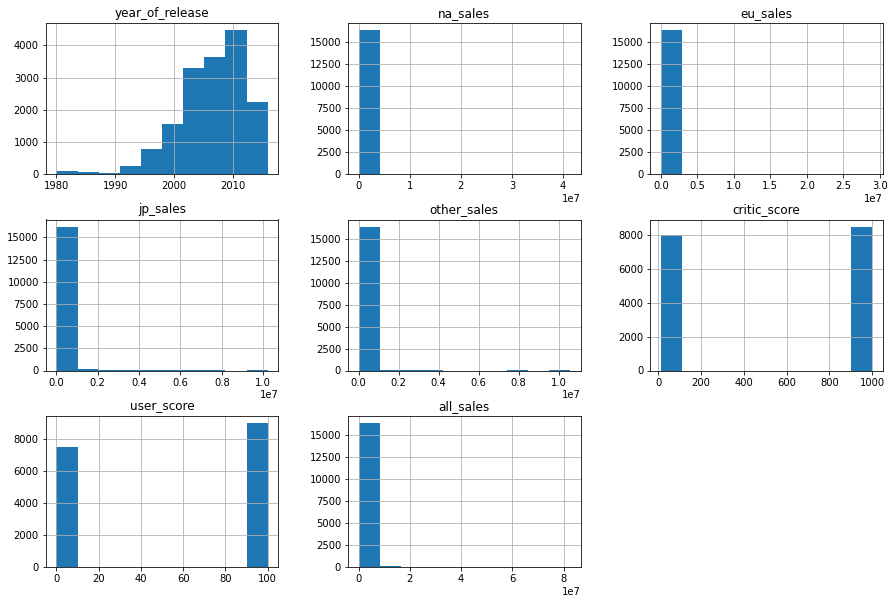

In [41]:
df.hist(figsize=(15, 10))
plt.show()#построим гистограмму для всех числовых значений

Видим, что пик на выход игр пришелся на 2009-2013 годы.
Также видим, что большинство игр оценены критиками на оценку от 65 до 70, а пользоватлями на ~7.8-8.8.
Продажи по выведенным графикам оценить сложно, далее посмотрим подробнее.

# 3.1. Зависимость ряда факторов от года выпуска

Определим период жизненного цикла платформы, выделим актуальный период для дальнейшего проведения анализа, выделим список популярных платформ, проверим зависимость количества выпущенных игр от года выпуска.

In [42]:
df_pivot_1 = df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index() #построим сводную таблицу в зависимости года выпуска и количества выпущенных игр
display(df_pivot_1)

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


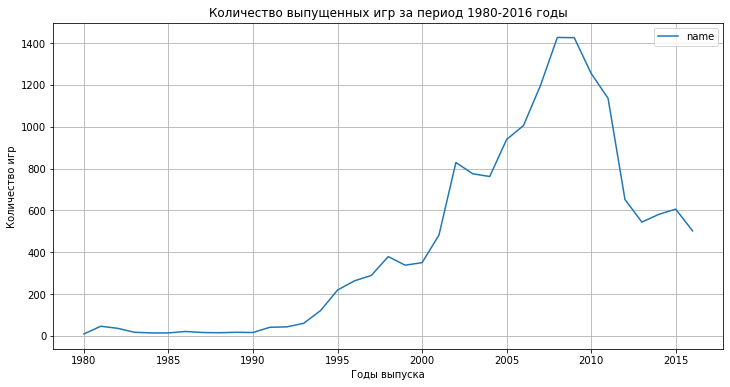

In [43]:
df_pivot_1.plot(x='year_of_release', y='name', grid=True, figsize=(12,6))
plt.title('Количество выпущенных игр за период 1980-2016 годы')
plt.ylabel('Количество игр')
plt.xlabel('Годы выпуска')
plt.show()

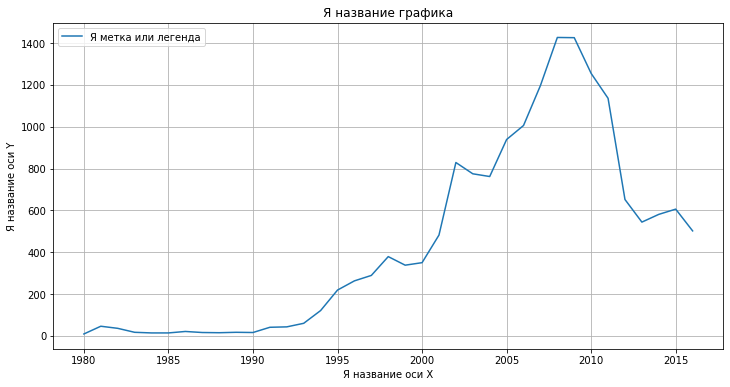

In [44]:
# Комментарий ревьюера
df_pivot_1.plot(x='year_of_release', y='name', grid=True, figsize=(12,6))
plt.title('Я название графика')
plt.xlabel('Я название оси Х')
plt.ylabel('Я название оси Y')
plt.legend(['Я метка или легенда'])
plt.show()

Видим, что значительный рост компьютерных игр пришелся на на начало 2000-х. Далее видим положительную динамику до 2009 года и резкий спад, начиная с 2010 года.

Предположим, что спад с 2010 года связан с появлением смартфонов и планшетов, которые могли снизить у части пользователей потребность в компьютерных играх:

    - т.к. смартфоны и планшеты также дают возможность скачивать игры на устройство
    - т.к. вместе со смартфонами стали популязироваться социальные сети, пользователи стали больше времени уделять им

В связи с этими факторами рынок мог перестроиться под потребности и интересы пользователей и сделать упор на другие продукты.

Предлагаю для дальнейшего анализа взять данные, начиная с 2005 года. 
Запишем их в отдельный датафрейм.

In [45]:
df_new = df.query('year_of_release >= 2005') #создадим таблицу, где год выпуска игры больше либо равен 2005

In [46]:
display(df_new.head()) #выведем первые 5 строк таблицы
df_new.info() #посмотрим инфо таблицы

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41360000.0,28960000.0,3770000.0,8450000.0,76.0,8.0,E,82540000.0
2,Mario Kart Wii,Wii,2008,Racing,15680000.0,12760000.0,3790000.0,3290000.0,82.0,8.3,E,35520000.0
3,Wii Sports Resort,Wii,2009,Sports,15610000.0,10930000.0,3280000.0,2950000.0,80.0,8.0,E,32770000.0
6,New Super Mario Bros.,DS,2006,Platform,11280000.0,9140000.0,6500000.0,2880000.0,89.0,8.5,E,29800000.0
7,Wii Play,Wii,2006,Misc,13960000.0,9180000.0,2930000.0,2840000.0,58.0,6.6,E,28910000.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11271 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             11271 non-null  object 
 1   platform         11271 non-null  object 
 2   year_of_release  11271 non-null  int64  
 3   genre            11271 non-null  object 
 4   na_sales         11271 non-null  float64
 5   eu_sales         11271 non-null  float64
 6   jp_sales         11271 non-null  float64
 7   other_sales      11271 non-null  float64
 8   critic_score     11271 non-null  float64
 9   user_score       11271 non-null  float64
 10  rating           11271 non-null  object 
 11  all_sales        11271 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.1+ MB


Итак, данные сократились чуть больше чем на 5000 строк.
Сформируем информацию о том, в течение какого времени происходит цикл платформы. Возьмем для анализа период 2005-2016 годов.

In [47]:
df_new_pivot_1 = df_new.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='median')
df_new_pivot_1

year_of_release,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,145000.0,190000.0,100000.0,90000.0,90000.0,80000.0
DC,NaN,NaN,20000.0,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,130000.0,110000.0,115000.0,100000.0,110000.0,110000.0,80000.0,30000.0,150000.0,NaN,NaN,NaN
GBA,140000.0,40000.0,205000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,150000.0,155000.0,60000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC,30000.0,20000.0,20000.0,20000.0,40000.0,60000.0,80000.0,120000.0,175000.0,100000.0,80000.0,35000.0
PS2,310000.0,100000.0,120000.0,150000.0,165000.0,55000.0,60000.0,NaN,NaN,NaN,NaN,NaN
PS3,NaN,380000.0,420000.0,435000.0,345000.0,340000.0,240000.0,310000.0,310000.0,160000.0,50000.0,65000.0
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1530000.0,600000.0,180000.0,85000.0


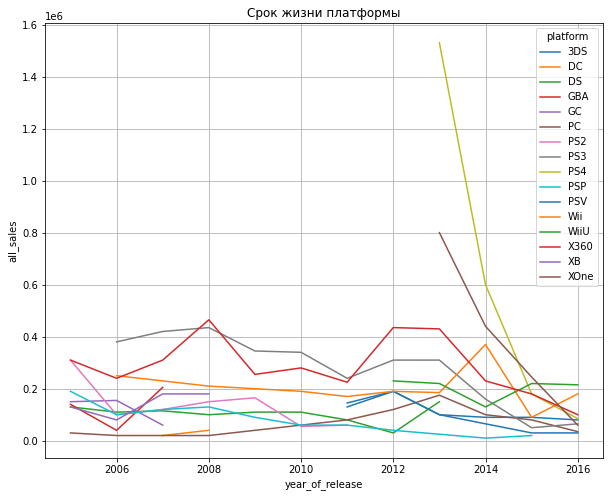

In [48]:
df_new.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='median').plot(grid=True, figsize=(10,8))
plt.ylabel('all_sales')
plt.title('Срок жизни платформы')
plt.show()

In [49]:
lifecycle_platform = df_new.groupby('platform')['year_of_release'].agg(['min', 'max'])
lifecycle_platform['lifecycle'] = lifecycle_platform['max'] - lifecycle_platform['min']
lifecycle_platform.sort_values(by='lifecycle', ascending=False)

,min,max,lifecycle
platform,,,
PC,2005,2016,11
X360,2005,2016,11
PS3,2006,2016,10
PSP,2005,2015,10
Wii,2006,2016,10
DS,2005,2013,8
PS2,2005,2011,6
3DS,2011,2016,5
PSV,2011,2016,5


Видим, что у каждой платформы срок жизни за последние 10 лет индивидуален
Есть платформы, которые стабильно находятся на рынке в течение всего выбранного периода.
Есть платформы, которые приходят и уходят за 2-3 года.

Посмотрим зависимость суммы продаж от платформы.
Сформируем сводную таблицу в разрезе платформ и года выхода со значением средней выручки.

In [50]:
df_new_pivot_2 = df_new.pivot_table(index=['year_of_release', 'platform'], values='all_sales', aggfunc='median').sort_values(by='all_sales', ascending=False).reset_index()
display(df_new_pivot_2) #построим сводную таблицу в разрезе платформ и года выхода со значением средней выручки

,year_of_release,platform,all_sales
0,2013,PS4,1530000.0
1,2013,XOne,800000.0
2,2014,PS4,600000.0
3,2008,X360,465000.0
4,2014,XOne,440000.0
...,...,...,...
105,2015,PSP,20000.0
106,2007,PC,20000.0
107,2007,DC,20000.0
108,2006,PC,20000.0


In [51]:
df_new_pivot_2.describe()

,year_of_release,all_sales
count,110.000000,1.100000e+02
mean,2010.600000,1.806818e+05
std,3.506743,1.853604e+05
min,2005.000000,1.000000e+04
25%,2007.000000,8.000000e+04
50%,2011.000000,1.350000e+05
75%,2014.000000,2.237500e+05
max,2016.000000,1.530000e+06


In [54]:
df_platform_pivot = df_new.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='median', margins=True)
display(df_platform_pivot) #немного переформируем талицу для более понятного восприятия

year_of_release,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All
platform,,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,145000.0,190000.0,100000.0,90000.0,90000.0,80000.0,120000.0
DC,NaN,NaN,20000.0,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.0
DS,130000.0,110000.0,115000.0,100000.0,110000.0,110000.0,80000.0,30000.0,150000.0,NaN,NaN,NaN,110000.0
GBA,140000.0,40000.0,205000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120000.0
GC,150000.0,155000.0,60000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150000.0
PC,30000.0,20000.0,20000.0,20000.0,40000.0,60000.0,80000.0,120000.0,175000.0,100000.0,80000.0,35000.0,50000.0
PS2,310000.0,100000.0,120000.0,150000.0,165000.0,55000.0,60000.0,NaN,NaN,NaN,NaN,NaN,160000.0
PS3,NaN,380000.0,420000.0,435000.0,345000.0,340000.0,240000.0,310000.0,310000.0,160000.0,50000.0,65000.0,280000.0
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1530000.0,600000.0,180000.0,85000.0,200000.0


Видим, что из 16 платформ 4 напротяжении всего выбранного периода держались на рынке и практически ежегодно имели доход. (PS3, PSP, Wii, X360)
Также видим, что есть платформы, которые в течение последних нескольких лет имеют доход. (PS4, PSV, WiiU, XOne, 3DS)

Посмотрим информацию о продаж внутри этих платформ.


In [55]:
df_platform_pivot_2 = df_platform_pivot.query('platform in ["PS3", "PSP", "Wii", "X360", "PS4", "PSV", "WiiU", "XOne", "3DS"]').reset_index()
display(df_platform_pivot_2) #создадим датафрейм с выбранными выше платформами

year_of_release,platform,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All
0,3DS,NaN,NaN,NaN,NaN,NaN,NaN,145000.0,190000.0,100000.0,90000.0,90000.0,80000.0,120000.0
1,PS3,NaN,380000.0,420000.0,435000.0,345000.0,340000.0,240000.0,310000.0,310000.0,160000.0,50000.0,65000.0,280000.0
2,PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1530000.0,600000.0,180000.0,85000.0,200000.0
3,PSP,190000.0,100000.0,120000.0,130000.0,90000.0,60000.0,60000.0,40000.0,25000.0,10000.0,20000.0,NaN,90000.0
4,PSV,NaN,NaN,NaN,NaN,NaN,NaN,130000.0,190000.0,100000.0,65000.0,30000.0,30000.0,50000.0
5,Wii,NaN,250000.0,230000.0,210000.0,200000.0,190000.0,170000.0,190000.0,185000.0,370000.0,90000.0,180000.0,190000.0
6,WiiU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230000.0,220000.0,130000.0,220000.0,215000.0,220000.0
7,X360,310000.0,240000.0,310000.0,465000.0,255000.0,280000.0,225000.0,435000.0,430000.0,230000.0,180000.0,100000.0,280000.0
8,XOne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800000.0,440000.0,245000.0,60000.0,220000.0


Заменим `NaN` на 0.

In [56]:
df_platform_pivot_2 = df_platform_pivot_2.fillna(0)
display(df_platform_pivot_2) #заменим NaN на 0

year_of_release,platform,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All
0,3DS,0.0,0.0,0.0,0.0,0.0,0.0,145000.0,190000.0,100000.0,90000.0,90000.0,80000.0,120000.0
1,PS3,0.0,380000.0,420000.0,435000.0,345000.0,340000.0,240000.0,310000.0,310000.0,160000.0,50000.0,65000.0,280000.0
2,PS4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1530000.0,600000.0,180000.0,85000.0,200000.0
3,PSP,190000.0,100000.0,120000.0,130000.0,90000.0,60000.0,60000.0,40000.0,25000.0,10000.0,20000.0,0.0,90000.0
4,PSV,0.0,0.0,0.0,0.0,0.0,0.0,130000.0,190000.0,100000.0,65000.0,30000.0,30000.0,50000.0
5,Wii,0.0,250000.0,230000.0,210000.0,200000.0,190000.0,170000.0,190000.0,185000.0,370000.0,90000.0,180000.0,190000.0
6,WiiU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230000.0,220000.0,130000.0,220000.0,215000.0,220000.0
7,X360,310000.0,240000.0,310000.0,465000.0,255000.0,280000.0,225000.0,435000.0,430000.0,230000.0,180000.0,100000.0,280000.0
8,XOne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800000.0,440000.0,245000.0,60000.0,220000.0


In [57]:
df_platform_pivot_2['sales'] = df_platform_pivot_2.sum(axis=1)
display(df_platform_pivot_2) #добавим столбец с итоговой суммой продаж за весь период

year_of_release,platform,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,All,sales
0,3DS,0.0,0.0,0.0,0.0,0.0,0.0,145000.0,190000.0,100000.0,90000.0,90000.0,80000.0,120000.0,815000.0
1,PS3,0.0,380000.0,420000.0,435000.0,345000.0,340000.0,240000.0,310000.0,310000.0,160000.0,50000.0,65000.0,280000.0,3335000.0
2,PS4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1530000.0,600000.0,180000.0,85000.0,200000.0,2595000.0
3,PSP,190000.0,100000.0,120000.0,130000.0,90000.0,60000.0,60000.0,40000.0,25000.0,10000.0,20000.0,0.0,90000.0,935000.0
4,PSV,0.0,0.0,0.0,0.0,0.0,0.0,130000.0,190000.0,100000.0,65000.0,30000.0,30000.0,50000.0,595000.0
5,Wii,0.0,250000.0,230000.0,210000.0,200000.0,190000.0,170000.0,190000.0,185000.0,370000.0,90000.0,180000.0,190000.0,2455000.0
6,WiiU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230000.0,220000.0,130000.0,220000.0,215000.0,220000.0,1235000.0
7,X360,310000.0,240000.0,310000.0,465000.0,255000.0,280000.0,225000.0,435000.0,430000.0,230000.0,180000.0,100000.0,280000.0,3740000.0
8,XOne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800000.0,440000.0,245000.0,60000.0,220000.0,1765000.0


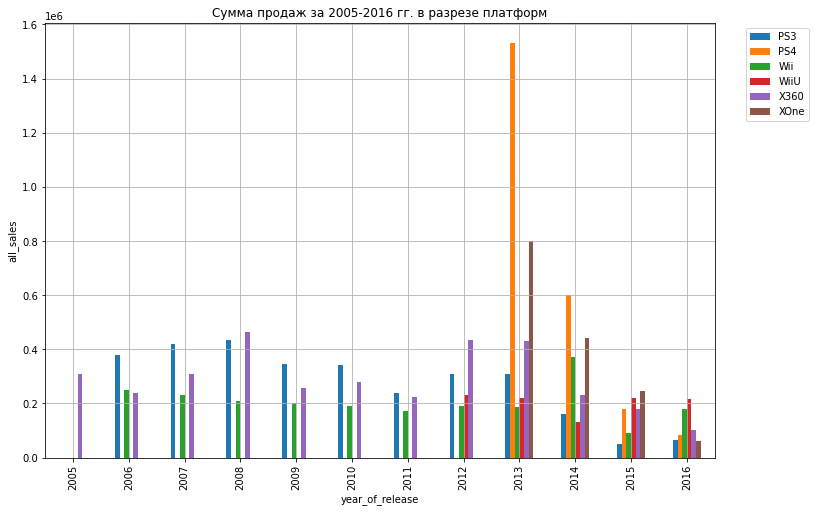

In [58]:
df_platform_sales = df_new.query('platform in ["PS3", "Wii", "X360", "PS4", "WiiU", "XOne"]').reset_index()
df_platform_sales.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='median').plot(grid=True, figsize=(12,8), kind='bar')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('all_sales')
plt.title('Сумма продаж за 2005-2016 гг. в разрезе платформ')
plt.show()

По среднему итогу продаж за все периоды видим, что лидером из категории платформ, стабильно выпускающих игры, является X360.
Лидером среди платформ, которые появились на рынке за последние 3-4 года является PS4.

PS4 - это модернизированная версия PS3, WiiU - модернизированная версия Wii, а XOne пришла на смену X360.

При таком сравнении видим, что PS4, начиная с 2013 года начала вытеснять PS3 с рынка, т.к. имеет резко высокий показатель по продажам прямо со старта, в то время как у PS3 продажи идут на спад и сводятся к 0.

Примерно то же самое происходит с платформами X360 и XOne.

В то время как Wii и WiiU остаются примерно на одном уровне продаж.
Видим, что, начиная с 2013 года на рынке появляется много новых платформ, увеличиваются суммы выручки с продаж, поэтому предлагаю взять для анализа период с 2013 по 2016 год.

В 2013 году на рынок вышло много новых платформ, увеличились продажи компьютерных игр. 
Возьмем для дальнейшего анализа срез данных за период с 2013 года и посмотрим долю рынка каждой платформы.

year_of_release,2013,2014,2015,2016,All
platform,,,,,
X360,430000.0,230000.0,180000.0,100000.0,265000.0
XOne,800000.0,440000.0,245000.0,60000.0,220000.0
PS4,1530000.0,600000.0,180000.0,85000.0,200000.0
WiiU,220000.0,130000.0,220000.0,215000.0,200000.0
Wii,185000.0,370000.0,90000.0,180000.0,180000.0
DS,150000.0,NaN,NaN,NaN,150000.0
PS3,310000.0,160000.0,50000.0,65000.0,150000.0
All,190000.0,160000.0,90000.0,60000.0,110000.0
3DS,100000.0,90000.0,90000.0,80000.0,90000.0


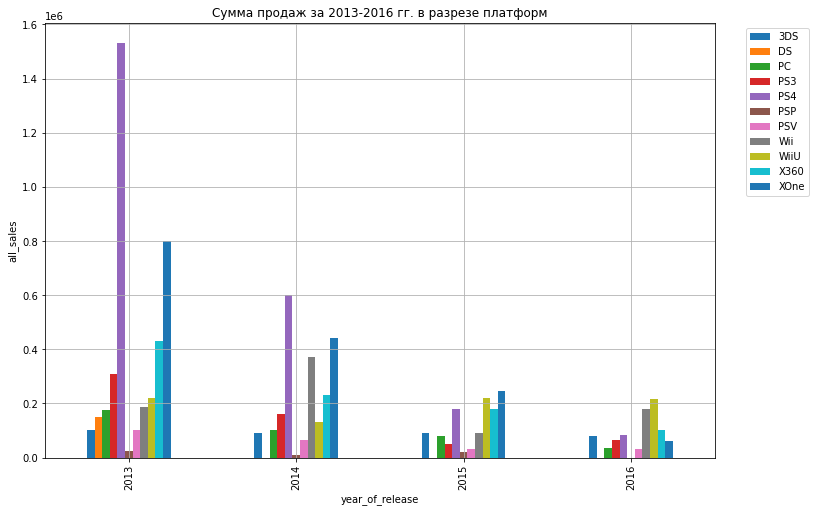

In [59]:
df_new_2 = df_new.query('year_of_release >= 2013').reset_index()
display(df_new_2.pivot_table(index='platform', columns='year_of_release', values='all_sales', aggfunc='median', margins=True).sort_values(by='All', ascending=False))
df_new_2.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='median').plot(grid=True, figsize=(12,8), kind='bar')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('all_sales')
plt.title('Сумма продаж за 2013-2016 гг. в разрезе платформ')
plt.show()

На графике мы видим динамику продаж в разрезе платформ за 2013-2016 годы.

Лидерами продаж за выбранный период являтся PS4, XOne, X360, WiiU. Определим их как потенциально прибыльные.

Однако мы видим резкий спад как у лидеров продаж, так и спад продаж игр в целом по всем платформам.

In [181]:
df_new_2

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,16,Grand Theft Auto V,PS3,2013,Action,7020000.0,9090000.0,980000.0,3960000.0,97.0,8.2,M,21050000.0
1,23,Grand Theft Auto V,X360,2013,Action,9660000.0,5140000.0,60000.0,1410000.0,97.0,8.1,M,16270000.0
2,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6030000.0,5860000.0,360000.0,2380000.0,1000.0,100.0,no_rating,14630000.0
3,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5280000.0,4190000.0,4350000.0,780000.0,1000.0,100.0,no_rating,14600000.0
4,42,Grand Theft Auto V,PS4,2014,Action,3960000.0,6310000.0,380000.0,1970000.0,97.0,8.3,M,12620000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,16701,Strawberry Nauts,PSV,2016,Adventure,0.0,0.0,10000.0,0.0,1000.0,100.0,no_rating,10000.0
2229,16705,Aiyoku no Eustia,PSV,2014,Misc,0.0,0.0,10000.0,0.0,1000.0,100.0,no_rating,10000.0
2230,16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.0,0.0,10000.0,0.0,1000.0,100.0,no_rating,10000.0
2231,16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.0,0.0,10000.0,0.0,1000.0,100.0,no_rating,10000.0


Построим диаграмму размаха, посмотрим выбросы и аномальные значения. 

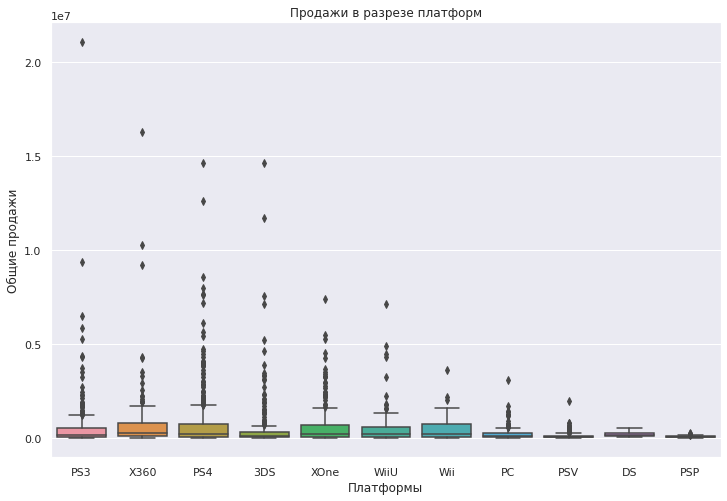

In [61]:
sns.set(rc={"figure.figsize":(12,8)})
sns.boxplot(data=df_new_2, x='platform', y='all_sales')
plt.title('Продажи в разрезе платформ')
plt.ylabel('Общие продажи')
plt.xlabel('Платформы')
plt.show()

Увеличим диапозон оси у, чтобы более явно увидеть значения продаж.

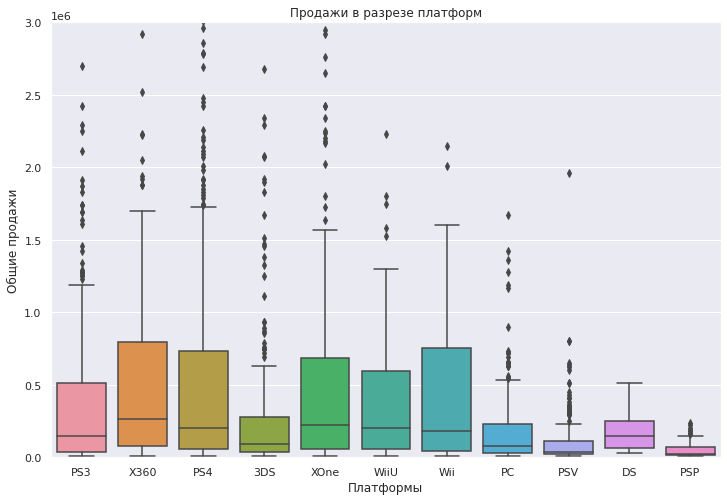

In [62]:
sns.set(rc={"figure.figsize":(12,8)})
sns.boxplot(data=df_new_2, x='platform', y='all_sales')
plt.ylim(0, 3000000)
plt.title('Продажи в разрезе платформ')
plt.ylabel('Общие продажи')
plt.xlabel('Платформы')
plt.show()

# Вывод

На графике видим аномальные выбросы в продажах в размере 800 000 рублей у XOne и в размере 1.5 млн. у PS4. Пока непонятно, но предположим, что эти цифры реальны. Оставим, как есть.

Видим, что за последние 3 года лидерами продаж стали игры на платформе XOne, Х360, PS4, Wii и WiiU.
Также видим, что платформы PS4 и XOne появились в 2013 году с аномально высоким стартом продаж, но, к сожалению, резко упали к следующему году.
Медианные значения платформ PS3, PS4, XOne, X360 находятся на уровне 200 - 250 тысяч, медианные значения 3DS на уровне 70 тысяч.

Предлагаю более детально рассмотреть информацию за период 2013-2016 гг.

# 3.2. Зависимость количества выпущенных игр от платформы

Сформируем информацию о количестве выпущенных игр по платформам.

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,91.0,8.0,38.0,126.0,16.0,54.0,63.0,12.0,42.0,75.0,19.0
2014,80.0,NaN,47.0,108.0,75.0,10.0,100.0,6.0,31.0,63.0,61.0
2015,86.0,NaN,50.0,73.0,137.0,3.0,110.0,4.0,28.0,35.0,80.0
2016,46.0,NaN,54.0,38.0,164.0,NaN,85.0,1.0,14.0,13.0,87.0


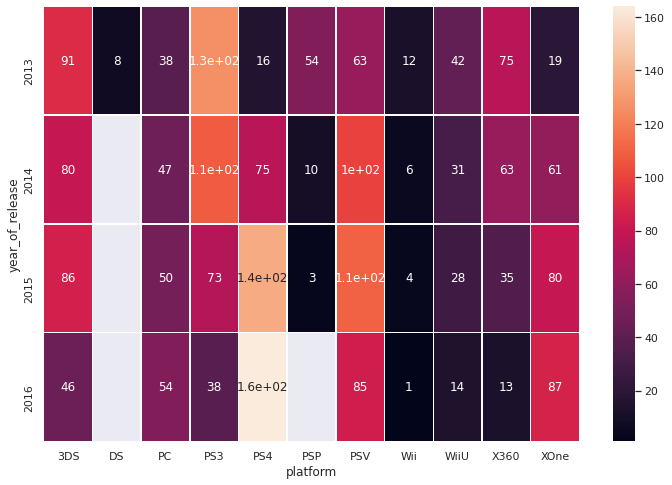

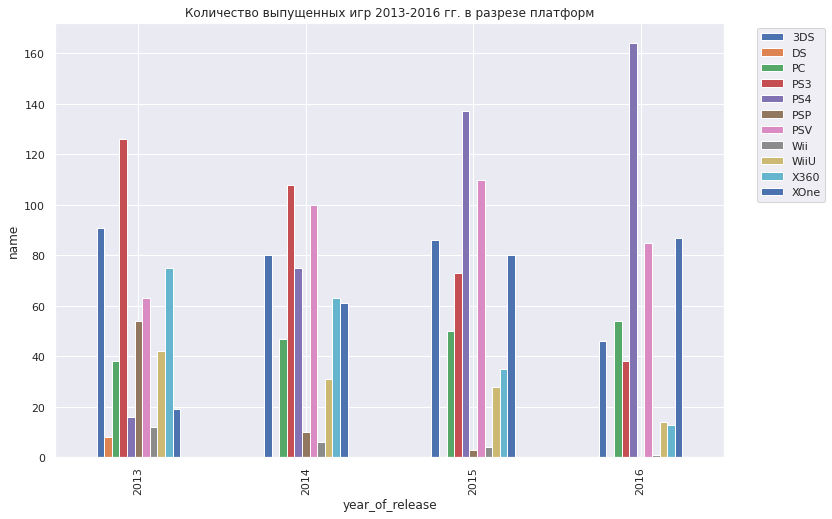

In [68]:
df_new_2_pivot = df_new_2.pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count')
display(df_new_2_pivot)
sns.heatmap(df_new_2_pivot, linewidths=.5, annot=True)
df_new_2.pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count').plot(grid=True, figsize=(12,8), kind='bar')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('name')
plt.title('Количество выпущенных игр 2013-2016 гг. в разрезе платформ')
plt.show()

# Вывод

Видим, что больше всего выпускают игры платформы PS4, PS3 и PSV. Их можно выделить как платформы с большим ассортиментом продукта.
Также заметен спад среди выпускаемых игр на платформе PS3 и параллельный рост выпускаемых игр на платформе PS4.
Аналогичная ситуация с Xbox - спад по X360 и рост по XOne.

# 3.3. Влияние оценки пользователя на продажи внутри платформы

Ранее лидерами продаж были определены платформы XOne, Х360, PS4, Wii и WiiU.

Посмотрим на примере данных платформ, как оценки пользователей и критиков влияют на продажи.

Создадим две таблицы:

df_user_score - здесь уберем заглушки, установленные в оценках пользователей

df_critic_score - здесь уберем заглушки, установленные в оценке критиков

In [77]:
df_user_score = df_new_2.query('user_score != 100')
df_critic_score = df_new_2.query('critic_score != 1000')

In [78]:
df_user_score.describe()

,index,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
count,1192.000000,1192.000000,1.192000e+03,1.192000e+03,1.192000e+03,1.192000e+03,1192.000000,1192.000000,1.192000e+03
mean,7421.253356,2014.433725,2.903356e+05,2.607131e+05,4.518456e+04,8.056208e+04,240.312919,6.584564,6.767953e+05
std,4956.700250,1.093744,6.137348e+05,6.089559e+05,1.415014e+05,1.967992e+05,357.722742,1.610413,1.363305e+06
min,16.000000,2013.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,13.000000,0.200000,1.000000e+04
25%,3066.500000,2013.000000,2.000000e+04,2.000000e+04,0.000000e+00,1.000000e+04,68.000000,5.800000,8.000000e+04
50%,6841.000000,2014.000000,9.000000e+04,8.000000e+04,0.000000e+00,2.000000e+04,77.000000,7.000000,2.400000e+05
75%,11690.000000,2015.000000,3.000000e+05,2.600000e+05,3.000000e+04,7.250000e+04,87.000000,7.800000,6.600000e+05
max,16690.000000,2016.000000,9.660000e+06,9.090000e+06,2.620000e+06,3.960000e+06,1000.000000,9.300000,2.105000e+07


In [79]:
df_critic_score.describe()

,index,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
count,991.000000,991.000000,9.910000e+02,9.910000e+02,9.910000e+02,9.910000e+02,991.000000,991.000000,9.910000e+02
mean,7244.651867,2014.419778,3.067205e+05,2.786276e+05,5.003027e+04,8.606458e+04,72.023209,8.150656,7.214430e+05
std,4906.341089,1.124283,6.506404e+05,6.471777e+05,1.523615e+05,2.114482e+05,12.841318,11.489322,1.454554e+06
min,16.000000,2013.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,13.000000,1.000000,1.000000e+04
25%,2839.500000,2013.000000,2.000000e+04,2.000000e+04,0.000000e+00,1.000000e+04,66.000000,6.000000,8.000000e+04
50%,6779.000000,2014.000000,9.000000e+04,8.000000e+04,0.000000e+00,2.000000e+04,74.000000,7.100000,2.400000e+05
75%,11443.500000,2015.000000,3.300000e+05,2.700000e+05,4.000000e+04,8.000000e+04,81.000000,7.900000,7.200000e+05
max,16690.000000,2016.000000,9.660000e+06,9.090000e+06,2.620000e+06,3.960000e+06,97.000000,100.000000,2.105000e+07


In [80]:
# Комментарий ревьюера
print(len(df.query('(year_of_release >= 2013) and user_score < 100') ))
print(len(df.query('(year_of_release >= 2013) and critic_score < 1000') ))
print(len(df.query('(year_of_release >= 2013) and user_score < 100 and critic_score < 1000') ))
print(len(df.query('all_sales >= 150000 and (year_of_release >= 2013) and user_score < 100 and critic_score < 1000') ))

1192
991
976
622


Сделаем функцию для вывода графиков и корреляции по платформам.
Проверим корреляцию и влияние оценок на продаже на примере популярных платформ XOne, Х360, PS4, WiiU, 3DS.

In [85]:
def user_score(plat):
      
    df_user_score.query('platform == @plat')[['all_sales', 'user_score']].plot(kind='scatter',
                                                                              x='user_score',
                                                                              y='all_sales',
                                                                              alpha=0.5,
                                                                              title='Влияние оценок пользователей на продажи',
                                                                              xlabel='Сумма продаж',
                                                                              ylabel='Оценки пользователей');
    plt.show()
    print('Корредяция между продажами и оценками пользователей:')
    return df_user_score.query('platform == @plat')[['all_sales', 'user_score']].corr()

In [86]:
def critic_score(plat):
    
    df_critic_score.query('platform == @plat')[['all_sales', 'critic_score']].plot(kind='scatter',
                                                                              x='critic_score',
                                                                              y='all_sales',
                                                                              alpha=0.5,
                                                                              title='Влияние оценок критиков на продажи',
                                                                              xlabel='Сумма продаж',
                                                                              ylabel='Оценки критиков');
    plt.show()
    print('Корредяция между продажами и оценками критиков:')
    return df_user_score.query('platform == @plat')[['all_sales', 'critic_score']].corr()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


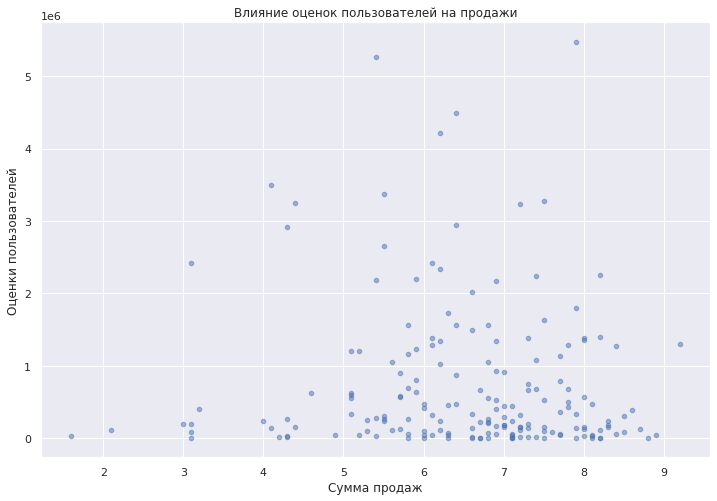

Корредяция между продажами и оценками пользователей:


,all_sales,user_score
all_sales,1.000000,-0.068925
user_score,-0.068925,1.000000


In [87]:
user_score('XOne')

Корреляция отрицательная и практически равна 0. Влияние оценок на продажи внутри данной платформы отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


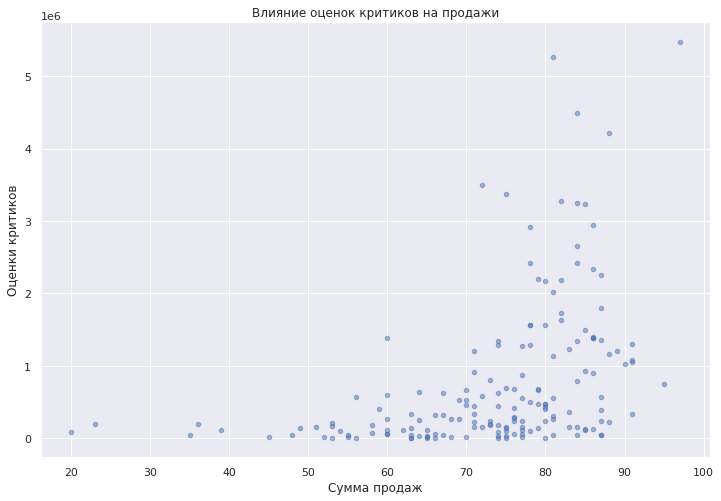

Корредяция между продажами и оценками критиков:


,all_sales,critic_score
all_sales,1.000000,-0.139645
critic_score,-0.139645,1.000000


In [89]:
critic_score('XOne')

Корреляция отрицательная и близка к 0. Влияние оценок критиков на продажи очень слабое, можно утверждать, что оно отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


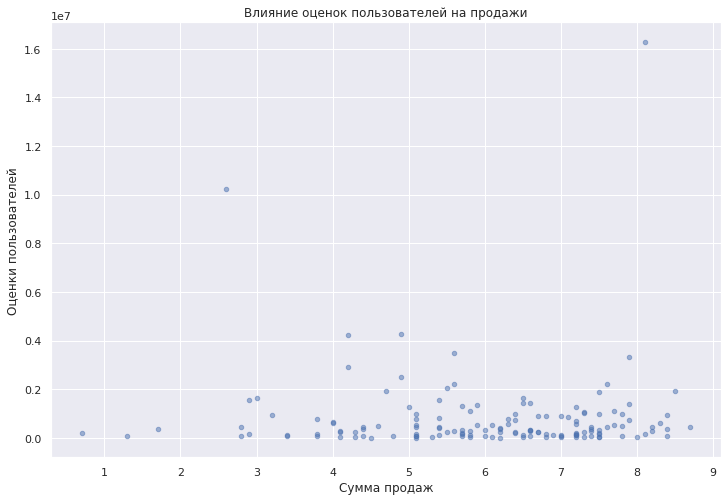

Корредяция между продажами и оценками пользователей:


,all_sales,user_score
all_sales,1.000000,-0.011742
user_score,-0.011742,1.000000


In [90]:
user_score('X360')

Корреляция отрицательная и практически равна 0. Влияние оценок пользователей на продажи внутри платформы X360 отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


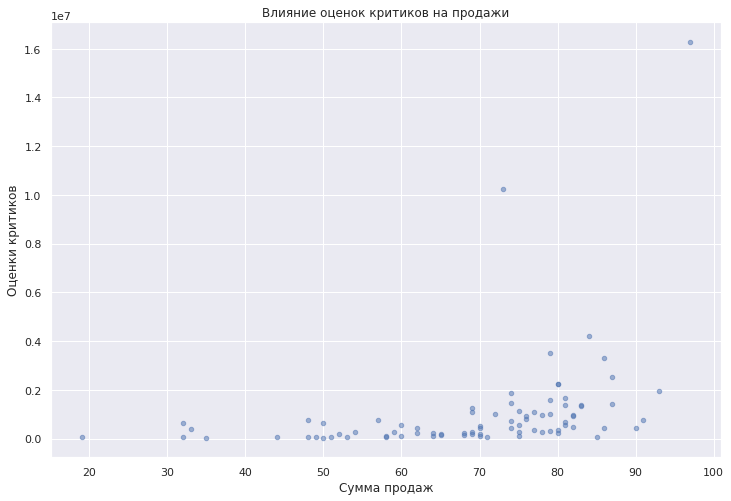

Корредяция между продажами и оценками критиков:


,all_sales,critic_score
all_sales,1.000000,-0.151274
critic_score,-0.151274,1.000000


In [91]:
critic_score('X360')

Корреляция отрицательная и близка к 0. Можно утверждать, что влияние оценок критиков на продажи внутри платформы Х360 отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


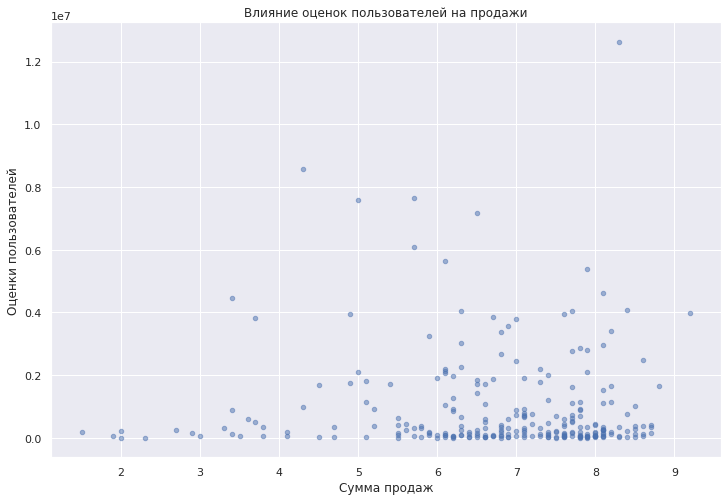

Корредяция между продажами и оценками пользователей:


,all_sales,user_score
all_sales,1.000000,-0.031957
user_score,-0.031957,1.000000


In [92]:
user_score('PS4')

Корреляция отрицательная, практически равна 0. Влияние оценок пользователей на продажи здесь отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


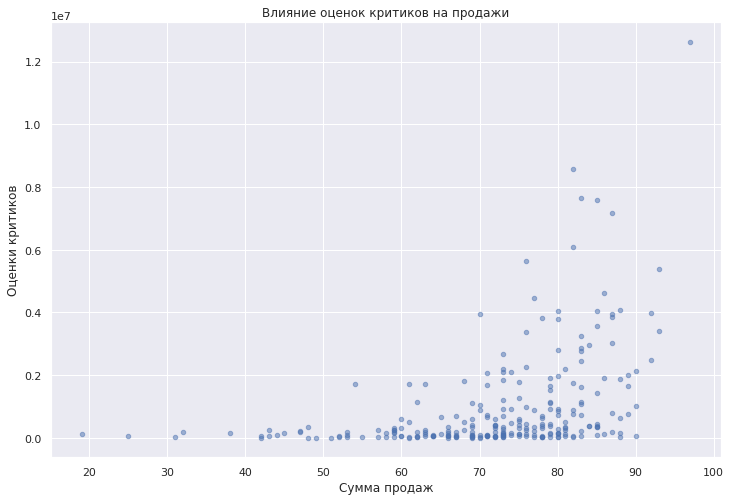

Корредяция между продажами и оценками критиков:


,all_sales,critic_score
all_sales,1.000000,-0.065072
critic_score,-0.065072,1.000000


In [93]:
critic_score('PS4')

Корреляция слишком слабая, близка к 0. Влияние оценок критиков на продажи внутри платформы PS4 отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


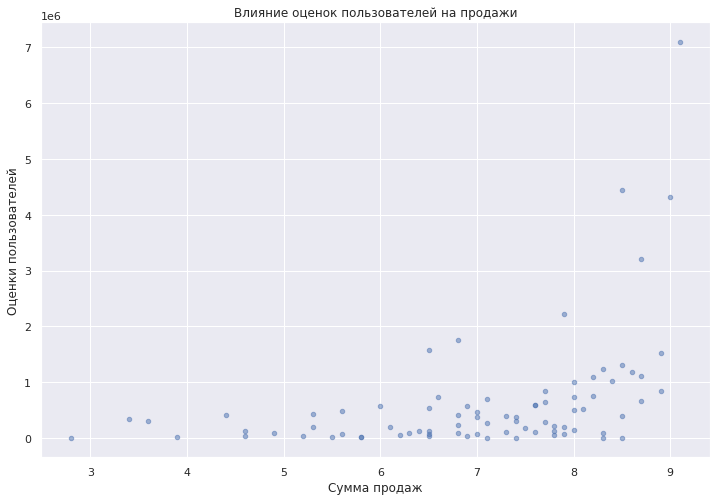

Корредяция между продажами и оценками пользователей:


,all_sales,user_score
all_sales,1.00000,0.41933
user_score,0.41933,1.00000


In [94]:
user_score('WiiU')

Внутри платформы Wii корреляция между продажами и оценками пользователей составляет почти 0.4, что говорит о том, что влияние оценок пользователей на продажи среди игр платформы Wii недостаточно сильное, но имеет место быть.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


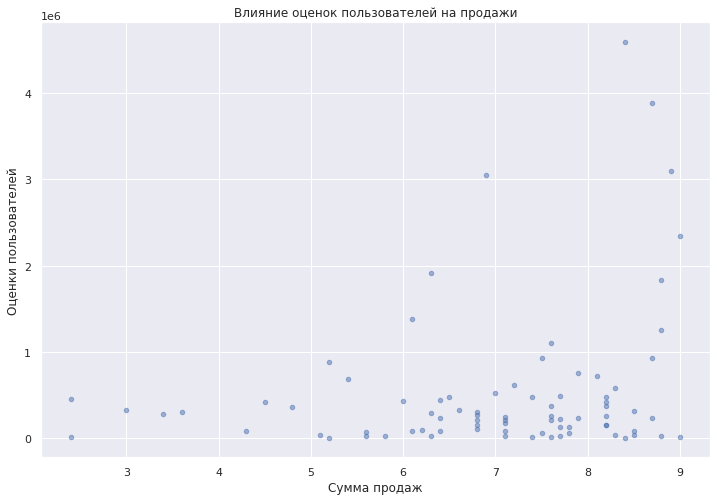

Корредяция между продажами и оценками пользователей:


,all_sales,user_score
all_sales,1.000000,0.241504
user_score,0.241504,1.000000


In [95]:
user_score('3DS')

Корреляция между продажами и оценками пользователей игр платформы 3DS выше, чем в других рассмотренных выше платформах, но также слишком низкая, чтобы утверждать о влиянии оценок на продажи.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


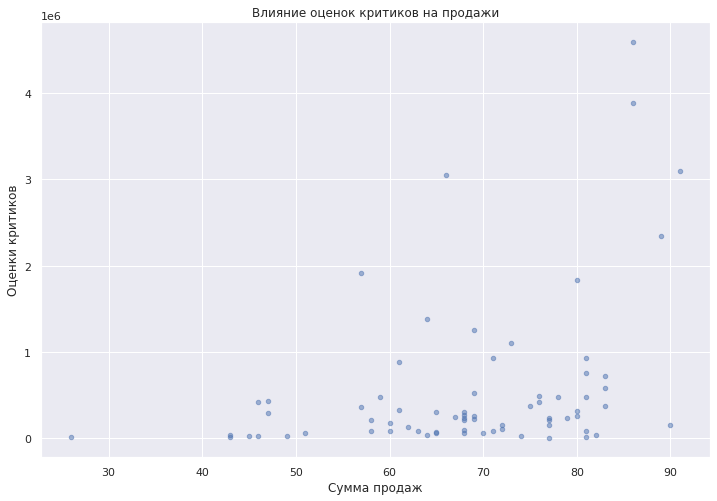

Корредяция между продажами и оценками критиков:


,all_sales,critic_score
all_sales,1.000000,-0.143098
critic_score,-0.143098,1.000000


In [96]:
critic_score('3DS')

Корреляция между продажами и оценками критиков слишком низкая, близка к 0. Влияние на продажи отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


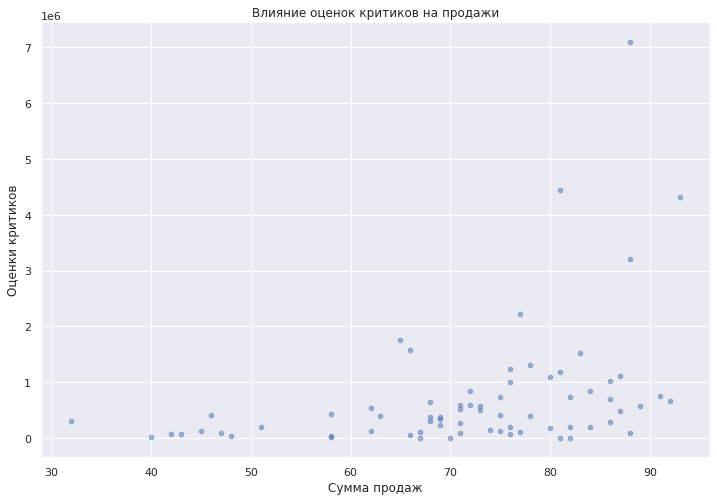

Корредяция между продажами и оценками критиков:


,all_sales,critic_score
all_sales,1.000000,-0.186326
critic_score,-0.186326,1.000000


In [97]:
critic_score('WiiU')

Корреляция между продажами и оценками критиков достаточно низкая, влияние оценок критиков на продажи игр платформы WiiU отсутствует.

Теперь посмотрим на влияние оценок пользователей и критиков сразу на все платформы.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


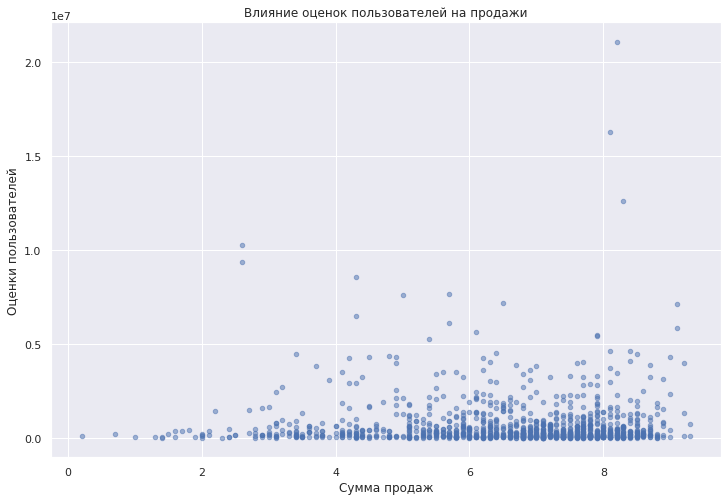

In [98]:
df_user_score[['all_sales', 'user_score']].plot(kind='scatter',
                                                x='user_score',
                                                y='all_sales',
                                                alpha=0.5,
                                                title='Влияние оценок пользователей на продажи',
                                                xlabel='Сумма продаж',
                                                ylabel='Оценки пользователей')
plt.show()

In [99]:
df_user_score[['all_sales', 'user_score']].corr()

,all_sales,user_score
all_sales,1.000000,-0.002608
user_score,-0.002608,1.000000


Корреляция между оценками пользователей и продажами практически равна 0, можно смело утверждать, что влияние оценок пользователей на продажи отсутствует.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


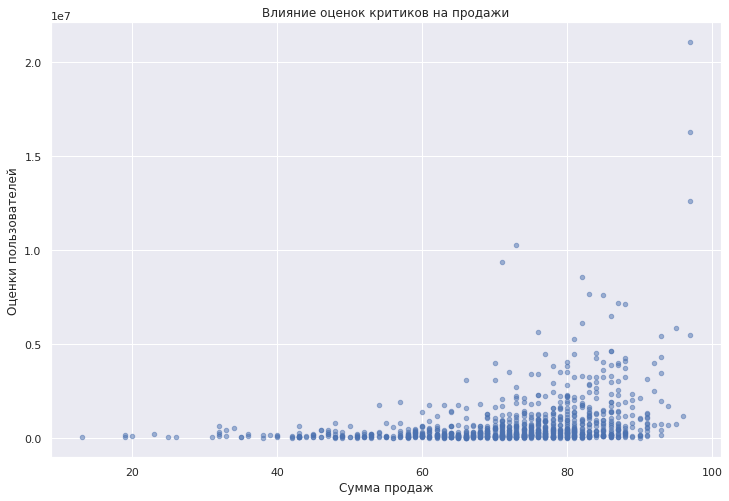

In [100]:
df_critic_score[['all_sales', 'critic_score']].plot(kind='scatter',
                                                x='critic_score',
                                                y='all_sales',
                                                alpha=0.5,
                                                title='Влияние оценок критиков на продажи',
                                                xlabel='Сумма продаж',
                                                ylabel='Оценки пользователей')
plt.show()

In [101]:
df_critic_score[['all_sales', 'critic_score']].corr()

,all_sales,critic_score
all_sales,1.0000,0.3137
critic_score,0.3137,1.0000


Корреляция между оценками критиков и продажам составляет 0.3 и значительно выше, чем корреляция между оценками пользователей и продажами, но все равно сложно утверждать, что влияние на продажи присутствует.

На основе проведенного исследования можно сделать вывод, что оценки пользователей и оценки критиков, как ни странно, не оказывают влияние на продажи.

# 3.5. Зависимость продаж от жанра игры

,all_sales
genre,
Shooter,450000.0
Sports,240000.0
Platform,225000.0
Fighting,125000.0
Role-Playing,125000.0
Racing,120000.0
Action,110000.0
Misc,100000.0
Simulation,100000.0


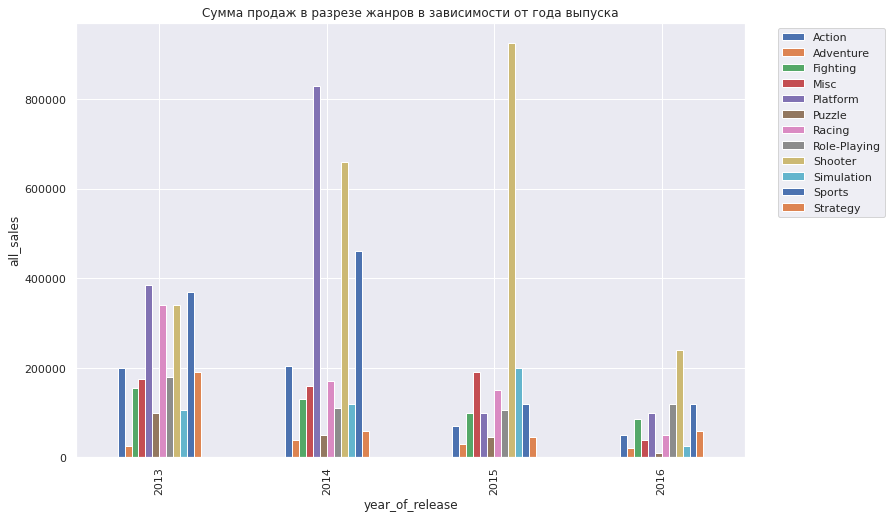

In [108]:
df_pivot = df_new_2.pivot_table(index='genre', values='all_sales', aggfunc='median').sort_values(by='all_sales', ascending=False)
display(df_pivot)
df_new_2.pivot_table(index='year_of_release', columns='genre', values='all_sales', aggfunc='median').plot(grid=True, figsize=(12,8), kind='bar')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('all_sales')
plt.title('Cумма продаж в разрезе жанров в зависимости от года выпуска')
plt.show() #построим сводную таблицу в разрезе жанров и сумм продаж

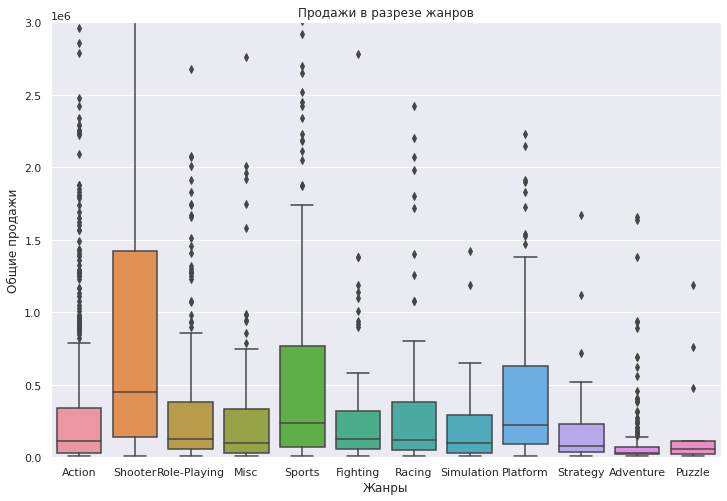

In [109]:
sns.set(rc={"figure.figsize":(12,8)})
sns.boxplot(data=df_new_2, x='genre', y='all_sales')
plt.title('Продажи в разрезе жанров')
plt.ylim(0, 3000000)
plt.ylabel('Общие продажи')
plt.xlabel('Жанры')
plt.show()

Видим, что в 2013 году жанры Platform, Sports, Racing и Shooter по продажам были приблизительно на одном уровне (Platform и Sports немного лидировали).
Далее в 2014 году произошел резкий скачок продаж среди игр жанра Platform, и менее резкий, но в то же время довольно значительный, рост среди жанров Shooter и Sports.
Далее в 2015 году резко набирает популярность жанр Shooter, в то время как в разрезе остальных жанров продажи падают.
И к 2016 году резко снижаются продажи по всем направлениям, но в то же время среди лидерв остается жанр Shooter.

Самыми прибыльными жанрами за весь выбранный период можем выделить жанры Shooter, Sports и Platform.

Посмотрим, какое количество игр выпускается в том или ином жанре.

Сформируем сводную таблицу с информацией о количестве игр в разрезе жанров.

,name
genre,
Action,766
Role-Playing,292
Adventure,245
Sports,214
Shooter,187
Misc,155
Racing,85
Fighting,80
Platform,74


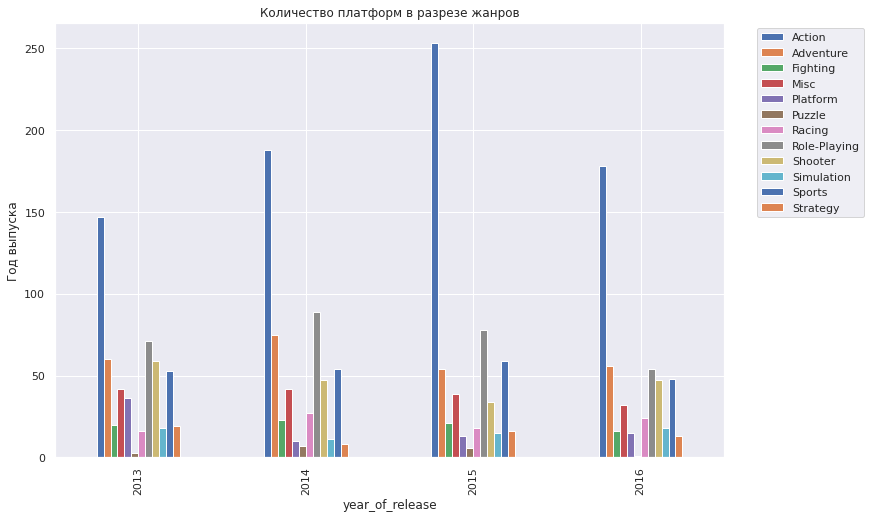

In [110]:
df_platform_4_pivot = df_new_2.pivot_table(index='genre', values='name', aggfunc='count').sort_values(by='name', ascending=False)
display(df_platform_4_pivot)
df_new_2.pivot_table(index='year_of_release', columns='genre', values='platform', aggfunc='count').plot(grid=True, figsize=(12,8), kind='bar')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('Количество игр')
plt.ylabel('Год выпуска')
plt.title('Количество платформ в разрезе жанров')
plt.show()

Видим, что больше всего игр выпущено в жанре Action, далее Adventure и Role-Playing.
То есть для данных жанров используется больше всего платформ для реализации этой идеи.
Можно заметить, что данные жанры, несмотря на большой объем использования, не являются лидерами продаж.

# Вывод

Итак, в данном блоке был проведен достаточно большой объем исследований. Подведем итоги:
1. Нет какого-то определенного закономерного срока жизненного цикла платформы, существуют различные сроки от 1 до 3 лет, а также и 8-9 лет.
1. Активный рост популярности компьютерных игр пришелся на начало 2000-х.
2. Пик популярность компьютерных игр пришелся на 2009-2010 годы, далее спрос пошел на спад.
3. Есть преположение, что спад популярности на компьютерные игры произошел с появлением смартфонов, которые также могут закрыть потребность пользователя в игре.
4. Также есть предположение, что спад популярности мог быть вызван ростом популярности социальных сетей, и пользователи стали больше времени проводить на этих платформах.
5. Были выявлены 3 платформы (PS3, X360, Wii), которые на протяжении 8-10 лет держались на рынке и далее нельзя сказать, что они исчезли с рынка - им на смену пришли более усовершенствованные версии (PS4, XOne, WiiU). Можно смело назвать данные платформы лидерами на рынке.
6. Лидером продаж за период 2005-2016 гг. является X360, лидером продаж за период 2013-2016 гг. является PS4.
7. В 2013 году есть аномальные продажи среди платформ PS4 и XOne. Данный пик продаж произошел в год выпуска данных платформ. Можно предположить, что были успешные рекламные кампании и маркетинговые акции, которые позволили из популярных платформ PS3 и X360 при создании их усовершенствованных версий собрать сливки с продаж.
8. Лидером по количеству выпускаемых игр среди платформ является PS4.
9. Взаимосвязь между продажами и оценками пользователей отсутствует, что довольно удивительно.
10. Взаимосвязь между продажами и оценками критиков слишком слаба, не прослеживается.
11. Самыми прибыльными жанрами являются Shooter, Sports и Platform, а самыми используемыми -  Action, Adventure и Role-Playing.

# 4. Составление портрета пользователя в разрезе регионов

# 4.1. Самые популярные платформы в разрезе регионов

Определим самые популярные платформы в разрезе регионов, посмотрим информацию о долях продаж платформ по регионам.

Сформируем сводную таблицу по продажам в Северной Америке, определим топ-5 платформ.

In [111]:
df_na = df_new_2.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
df_na

,na_sales
platform,
PS4,108740000.0
XOne,93120000.0
X360,81660000.0
PS3,63500000.0
3DS,38200000.0
WiiU,29210000.0
PC,11110000.0
Wii,6560000.0
PSV,5040000.0


Сформируем срез с топ-5 платформ, продаваемых в Северной Америке

In [112]:
df_na_top = df_na.query('platform in ["PS4", "XOne", "X360", "PS3", "3DS"]').reset_index()
df_na_top

,platform,na_sales
0,PS4,108740000.0
1,XOne,93120000.0
2,X360,81660000.0
3,PS3,63500000.0
4,3DS,38200000.0


In [1]:
temp = df_new_2.copy() 
list(temp.groupby('platform')['na_sales'].sum().sort_values(ascending=False).index[:5])

NameError: name 'df_new_2' is not defined

Объединим оставшиеся платформы под категорию "другие"

In [114]:
df_na_other = df_na.query('platform in ["WiiU", "PC", "Wii", "PSV", "DS", "PSP"]').sum()
df_na_other

na_sales    52490000.0
dtype: float64

Добавим строку в датафрейм со значением "Другие" ("other")

In [115]:
df_na_top.loc[len(df_na_top.index)] = ['other', 52490000.0]

In [116]:
df_na_top

,platform,na_sales
0,PS4,108740000.0
1,XOne,93120000.0
2,X360,81660000.0
3,PS3,63500000.0
4,3DS,38200000.0
5,other,52490000.0


Проделаем то же самое для Европейских стран и Японии

In [117]:
df_eu = df_new_2.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
df_eu

,eu_sales
platform,
PS4,141090000.0
PS3,67810000.0
XOne,51590000.0
X360,42520000.0
3DS,30960000.0
PC,25360000.0
WiiU,19850000.0
PSV,6100000.0
Wii,5930000.0


In [118]:
df_eu_top = df_eu.query('platform in ["PS4", "PS3", "XOne", "X360", "3DS"]').reset_index()

In [119]:
df_eu_other = df_eu.query('platform in ["WiiU", "PC", "Wii", "PSV", "DS", "PSP"]').sum()
df_eu_other

eu_sales    58260000.0
dtype: float64

In [120]:
df_eu_top.loc[len(df_eu_top.index)] = ['other', 58260000.0]
df_eu_top

,platform,eu_sales
0,PS4,141090000.0
1,PS3,67810000.0
2,XOne,51590000.0
3,X360,42520000.0
4,3DS,30960000.0
5,other,58260000.0


In [121]:
df_jp = df_new_2.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
df_jp

,jp_sales
platform,
3DS,67810000.0
PS3,23350000.0
PSV,18590000.0
PS4,15960000.0
WiiU,10880000.0
PSP,3290000.0
X360,510000.0
XOne,340000.0
Wii,50000.0


In [122]:
df_jp_top = df_jp.query('platform in ["3DS", "PS3", "PSV", "PS4", "WiiU"]').reset_index()

In [123]:
df_jp_other = df_jp.query('platform in ["PSP", "X360", "XOne", "Wii", "DS", "PC"]').sum()
df_jp_other

jp_sales    4190000.0
dtype: float64

In [124]:
df_jp_top.loc[len(df_jp_top.index)] = ['other', 4190000.0]
df_jp_top

,platform,jp_sales
0,3DS,67810000.0
1,PS3,23350000.0
2,PSV,18590000.0
3,PS4,15960000.0
4,WiiU,10880000.0
5,other,4190000.0


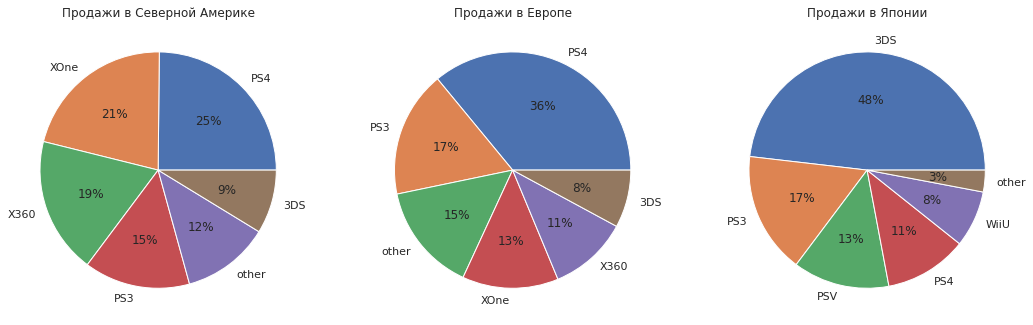

In [125]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

(df_na_top.groupby('platform')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie',
                                                                                 title='Продажи в Северной Америке',
                                                                                 autopct='%1.0f%%',
                                                                                 ylabel='',
                                                                                 ax = ax1)
);

(df_eu_top.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie',
                                                                                 title='Продажи в Европе',
                                                                                 autopct='%1.0f%%',
                                                                                 ylabel='',
                                                                                 ax = ax2)
);

(df_jp_top.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie',
                                                                                 title='Продажи в Японии',
                                                                                 autopct='%1.0f%%',
                                                                                 ylabel='',
                                                                                 ax = ax3)
);


plt.show()

После проведения этого анализа интересно посмотреть, какую долю от общей суммы продаж составляет каждый из регионов, чтобы понимать степень влияния каждого региона на общие продажи.

In [141]:
df_na_sales_share = df_new_2['na_sales'].sum()/df_new_2['all_sales'].sum()
df_eu_sales_share = df_new_2['eu_sales'].sum()/df_new_2['all_sales'].sum()
df_jp_sales_share = df_new_2['jp_sales'].sum()/df_new_2['all_sales'].sum()
df_other_sales_share = df_new_2['other_sales'].sum()/df_new_2['all_sales'].sum()
display(df_na_sales_share, df_eu_sales_share, df_jp_sales_share, df_other_sales_share)

0.4013147640484464

0.3596163896249163

0.1290742557463624

0.10999459058027487

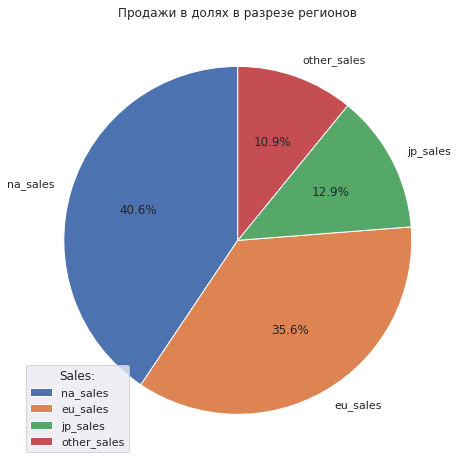

In [142]:
df_reg_pie = np.array([41., 36., 13., 11.])

mylabels = ["na_sales", "eu_sales", "jp_sales", "other_sales"]
plt.pie(df_reg_pie, labels = mylabels, startangle = 90, autopct='%1.1f%%')
plt.legend(title = "Sales:", loc="lower left")
plt.title('Продажи в долях в разрезе регионов')
plt.show()

# Вывод

Видим, что практически 80% рынка составляют Северная Америка (первое место, 41%) и Европа (второе место, 36%)

Вспомним лидеров продаж в данных регионах: в Северной Америке это PS4, а в Европе - это PS4 и PS3.
Эта информация также подтверждает анализ, который мы проводили при проверке лидеров продаж среди платформ.

В Японии наиболее популярны платформы 3DS и PS3.


# 4.2. Самые популярные жанры в разрезе регионов

Рассмотрим топ самых популярных жанров в разрезе регионов

Построим информацию о самых популярных жанрах в зависимости от суммы продаж в регионах.
Для этого сформируем сводные таблицы по регионам с информацией о жанре игры и сумме продаж.
Далее сделаем срезы самых популярных жанров в заисимости от суммы продаж и других.
Затем объединим их в одну таблицу для формирования графика.

In [143]:
df_genre_na = df_new_2.pivot_table(index='genre', values='na_sales', aggfunc='sum').reset_index().sort_values(by='na_sales',ascending=False)
df_genre_na #сформируем сводную таблицу с итоговым значением продаж в разрезе жанров

,genre,na_sales
0,Action,126050000.0
8,Shooter,109740000.0
10,Sports,65270000.0
7,Role-Playing,46400000.0
3,Misc,27490000.0
4,Platform,18140000.0
2,Fighting,15550000.0
6,Racing,12960000.0
1,Adventure,7140000.0
9,Simulation,4860000.0


In [144]:
df_genre_na_top = df_genre_na.query('na_sales > 20000000')
df_genre_na_other = df_genre_na.query('na_sales < 20000000')
df_genre_na_other['na_sales'].sum()

62760000.0

In [145]:
df_genre_na_top.loc[len(df_genre_na_top.index)] = ['other', 62760000.0]
df_genre_na_top

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,genre,na_sales
0,Action,126050000.0
8,Shooter,109740000.0
10,Sports,65270000.0
7,Role-Playing,46400000.0
3,Misc,27490000.0
5,other,62760000.0


In [146]:
df_genre_eu = df_new_2.pivot_table(index='genre', values='eu_sales', aggfunc='sum').reset_index().sort_values(by='eu_sales',ascending=False)
df_genre_eu

,genre,eu_sales
0,Action,118130000.0
8,Shooter,87860000.0
10,Sports,60520000.0
7,Role-Playing,36970000.0
6,Racing,20190000.0
3,Misc,20040000.0
4,Platform,15580000.0
9,Simulation,10920000.0
2,Fighting,8550000.0
1,Adventure,8250000.0


In [147]:
df_genre_eu_top = df_genre_eu.query('eu_sales > 20000000')
df_genre_eu_other = df_genre_eu.query('eu_sales < 20000000')
df_genre_eu_other['eu_sales'].sum()

48520000.0

In [148]:
df_genre_eu_top.loc[len(df_genre_eu_top.index)] = ['other', 48520000.0]
df_genre_eu_top

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


,genre,eu_sales
0,Action,118130000.0
8,Shooter,87860000.0
10,Sports,60520000.0
7,Role-Playing,36970000.0
6,other,48520000.0
3,Misc,20040000.0


In [149]:
df_genre_jp = df_new_2.pivot_table(index='genre', values='jp_sales', aggfunc='sum').reset_index().sort_values(by='jp_sales',ascending=False)
df_genre_jp

,genre,jp_sales
7,Role-Playing,51040000.0
0,Action,40490000.0
3,Misc,9200000.0
2,Fighting,7650000.0
8,Shooter,6610000.0
1,Adventure,5820000.0
10,Sports,5410000.0
4,Platform,4790000.0
9,Simulation,4520000.0
6,Racing,2300000.0


In [150]:
df_genre_jp_top = df_genre_jp.query('jp_sales > 6000000')
df_genre_jp_other = df_genre_jp.query('jp_sales < 6000000')
df_genre_jp_other['jp_sales'].sum()

25790000.0

In [151]:
df_genre_jp_top.loc[len(df_genre_jp_top.index)] = ['other', 25790000.0]
df_genre_jp_top

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,genre,jp_sales
7,Role-Playing,51040000.0
0,Action,40490000.0
3,Misc,9200000.0
2,Fighting,7650000.0
8,Shooter,6610000.0
5,other,25790000.0


После подготовки данных сформируем круговые диаграммы с информацией о долях продаж каждого жанра по регионам

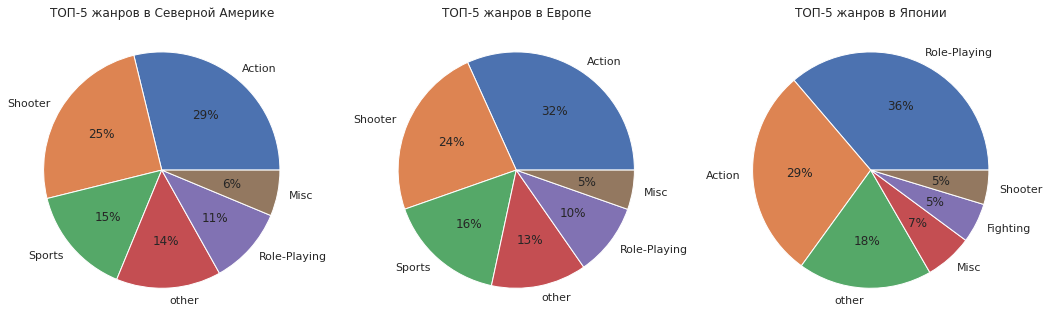

In [152]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

(df_genre_na_top.groupby('genre')['na_sales'].sum().sort_values(ascending=False).plot(kind='pie',
                                                                                 title='ТОП-5 жанров в Северной Америке',
                                                                                 autopct='%1.0f%%',
                                                                                 ylabel='',
                                                                                 ax = ax1)
);

(df_genre_eu_top.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).plot(kind='pie',
                                                                                 title='ТОП-5 жанров в Европе',
                                                                                 autopct='%1.0f%%',
                                                                                 ylabel='',
                                                                                 ax = ax2)
);

(df_genre_jp_top.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).plot(kind='pie',
                                                                                 title='ТОП-5 жанров в Японии',
                                                                                 autopct='%1.0f%%',
                                                                                 ylabel='',
                                                                                 ax = ax3)
);


plt.show()

# Вывод

Исходя из проведенного анализа, видим, что в Северной Америке и Европе популярны одни и те же жанры примерно в равном соотношении. Это Action, Shooter и Sports.
В Японии более популярны Role-Playing и Action.

# 4.3. Влияние рейтинга ESRB на продажи в регионах

Рассмотрим зависимость продаж от региона.

Посмотрим количество игр в разрезе рейтинга.

In [160]:
esrb_name = df_new_2.pivot_table(index='year_of_release', columns='rating', values='name', aggfunc='count', margins=True)
esrb_name #сформируем сводную таблицу и посмотрим на количество игр в разрезе рейтингов

rating,E,E10+,M,T,no_rating,All
year_of_release,,,,,,
2013,83,67,104,62,228,544
2014,66,84,116,79,236,581
2015,87,51,71,106,291,606
2016,66,50,78,86,222,502
All,302,252,369,333,977,2233


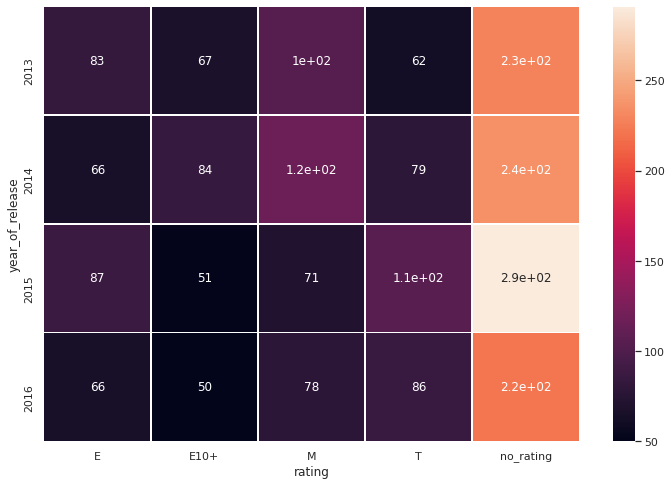

In [161]:
esrb_name_map = df_new_2.pivot_table(index='year_of_release', columns='rating', values='name', aggfunc='count')
sns.heatmap(esrb_name_map, linewidths=.5, annot=True)
plt.show()

Видим, что больше всего игр было выпущено и оценено рейтингом M в 2013-2014 годах - это категория игр для взрослых с ограничением 17+.

1. Ознакомимся с рейтингами в Северной Америке

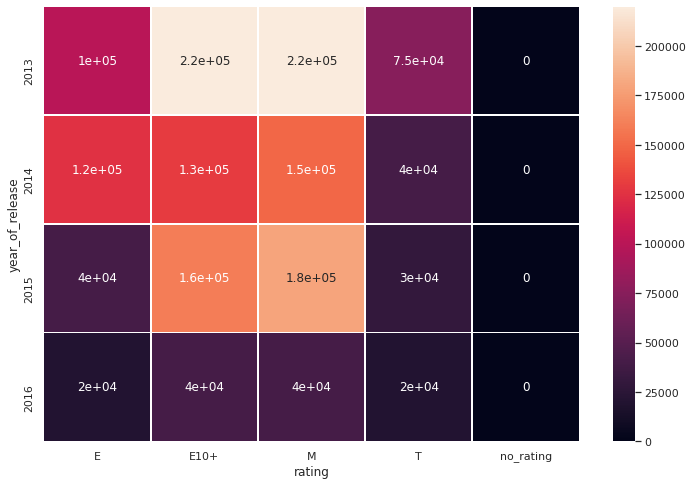

In [162]:
esrb_na_sales = df_new_2.pivot_table(index='year_of_release', columns='rating', values='na_sales', aggfunc='median')
sns.heatmap(esrb_na_sales, linewidths=.5, annot=True) 
plt.show()#посмотрим на сводную информацию по рейтингам в зависимости от суммы продаж в Северной Америке

Лидером продаж являются игры категории М в 2015 году и значительно с большим отрывом от других категорий в любой из периодов анализа.

Ознакомимся с рейтингами в Европе

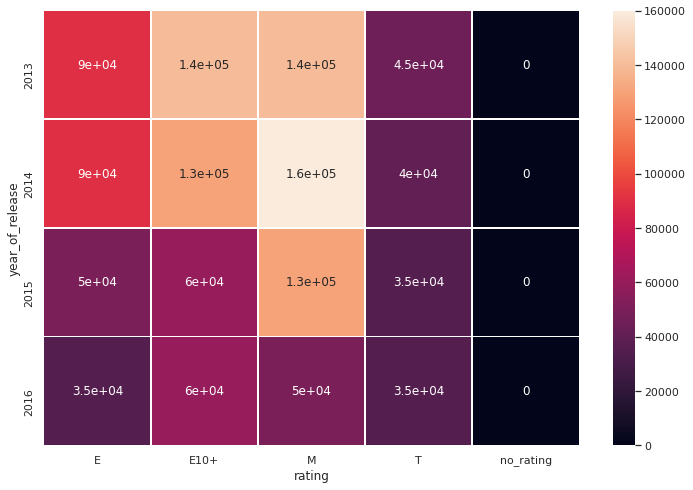

In [163]:
esrb_eu_sales = df_new_2.pivot_table(index='year_of_release', columns='rating', values='eu_sales', aggfunc='median')
sns.heatmap(esrb_eu_sales, linewidths=.5, annot=True)
plt.show()

Видим, что в Европе также наиболее популярны игры рейтинга М - категории 17+.
Более всего они популярны в 2015 году, но и в целом в другие годы тоже числятся в лидерах, но к 2016 году продажи игр данной категории значительно сокращаются.

В 2016 году лидером становятся игры категории Е - то есть для всех.

Ознакомимся с рейтингами в Японии

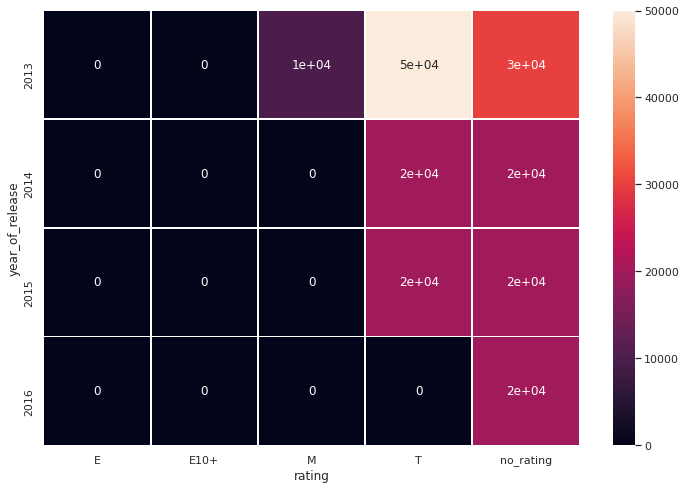

In [164]:
esrb_jp_sales = df_new_2.pivot_table(index='year_of_release', columns='rating', values='jp_sales', aggfunc='median')
sns.heatmap(esrb_jp_sales, linewidths=.5, annot=True)
plt.show()

Видим, что в Японии в целом данная система рейтингов не популярна, основная часть игр без рейтингов.
Но также можно отметить, что среди игр, имеющих информацию о рейтинге, в Японии крайне мало игр категории "для всех", есть, но в небольшом количеств, игры категории М (17+).
Большая часть среди оцененных игр - это игры рейтинга Т - для подростков.
То есть не исключено, не смотря на низкий процент информации, что в Японии большинство аудитории компьютерных игр - это подростки.

Ознакомимся с рейтингами в других странах

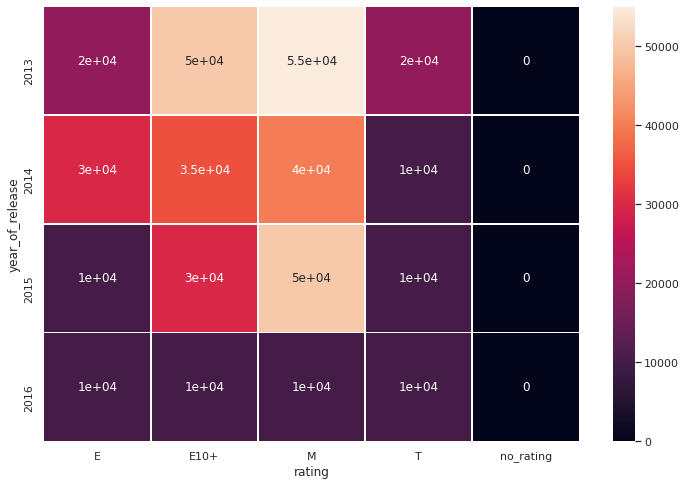

In [165]:
esrb_other_sales = df_new_2.pivot_table(index='year_of_release', columns='rating', values='other_sales', aggfunc='median')
sns.heatmap(esrb_other_sales, linewidths=.5, annot=True)
plt.show()

Видим, что в других странах лидером продаж среди пользователей являются игры категории М - т.е. 17+.

# Вывод

1. В Северной Америке большей популярностью пользуются платформы PS4 и XOne. Также в данном регионе популрны игры рейтинга М, т.е. 17+. Соответственно, под портрет клиента здесь подходят пользователи старше 17 лет, у которых есть потребность в играх на платформах Microsoft. 
Основными используемыми жанрами в Северной Америке являются Action, Shooter, Sports.
Также нельзя не отметить постепенный спад популярности компьютерных игр к 2016 году в Северной Америке.
В целом по продажам компьютерных игр Северная Америка занимает бОльшую долю рынка среди всех регионов.

2. Самыми популярными и продаваемыми платформами в Европе являются PS4 и PS3. И так же, как и в Северной Америке, популярны игры рейтинга М, т.е. категории 17+.
И так же, как и в Северной Америке, видим тенденцию по спаду популярности компьютерных игр.
Основными используемыми жанрами в Северной Америке являются Action, Shooter, Sports.
По доле рынка среди всех регионов Европа находится на втором месте - 36%

3. В Японии самыми восстребованными платформами являются 3DS и PS3,PSV. Пользователи Японии составляют небольшую долю среди всех продаж а именно 11%.
В Японии среди оцененных игр лидером является рейтинг Т, т.е. пользователи-подростки от 13 до 17 лет.
В целом портрет пользователя из Северной Америки чем-то схож с пользователем из Европы, в то время как в Японии совершенно другой портрет клиента.
Основным используемым в Японии жанром является Role-Playing и Action.


5. Самыми популярными жанрами игр являются Action, Role-Playing, Shooter и Sports.

# 5. Проверка гипотез

# 5.1. Гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [166]:
df_hypothesis = df_new_2.query('platform in ["XOne", "PC"] and user_score != 100').reset_index() #формируем таблицу с необходимыми платформами и оценкой пользователей
xone = df_hypothesis.query('platform == "XOne"').user_score.dropna().reset_index(drop=True) #удаляем пропуски
pc = df_hypothesis.query('platform == "PC"').user_score.dropna().reset_index(drop=True) #удаляем пропуски

In [167]:
df_hypothesis_pivot = df_hypothesis.pivot_table(index='platform', values='user_score') #формируем сводную таблицу
df_hypothesis_pivot

,user_score
platform,
PC,6.269677
XOne,6.521429


In [168]:
def info(df_hypothesis, title_1):
    
    df_hypothesis.hist(bins=50, range=(0,10))
    plt.title(title_1)
    plt.show()
 # напишем фунцию для построения графиков

In [169]:
xone.describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

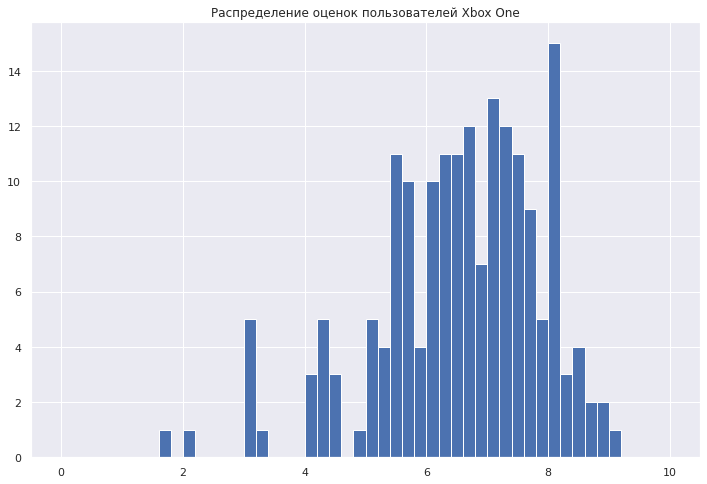

In [170]:
info(
    xone, 
    'Распределение оценок пользователей Xbox One'
)

In [171]:
pc.describe()

count    155.000000
mean       6.269677
std        1.742381
min        1.400000
25%        5.300000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

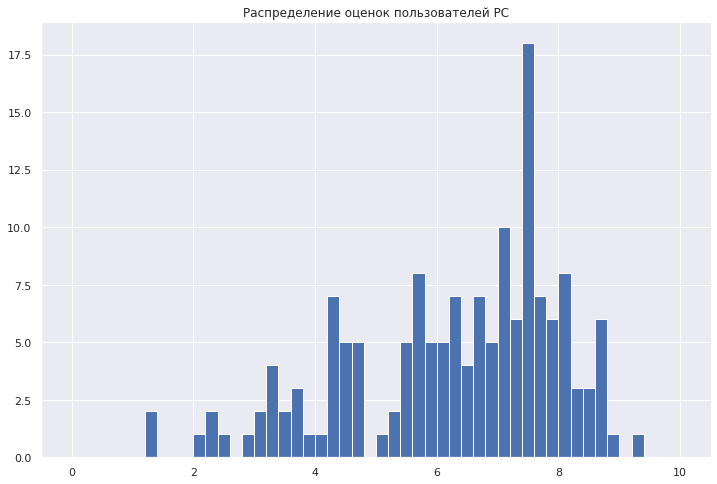

In [172]:
info(
    pc, 
    'Распределение оценок пользователей PC'
)

Глядя на графики, кажется, что оценок платформы PC визуально больше и они более плавно расположены, т.е. более стабильны и последовательны.

Разберем основную и альтернативную гипотезы:

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC различаются

Уровень значимости alpha установим 0.05.
Если p-value будет меньше выбранного уровня значимости 0.05, то нулевую гипотезу о равенстве средних отвергнем. 
Если p-value будет больше выбранного уровня значимости 0.05, делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.
В качестве уровня значимости устанавливаем предельно допустимый для нормального вывода показатель в 5%.
То есть мы допускаем, что наблюдаемое значение в нулевой гипотезе может оказаться с отклонением в 5% от предполагаемого. 

Выборки отличаются по размеру (отзывов на PC в 4 раза больше, чем на XOne). Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод st.ttest_ind, так же мы будем использовать параметр equal_var=True.

Если p-value будет меньше выбранного уровня значимости 0.05, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [173]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(xone, pc, equal_var=False)
print('p-значение: ', results.pvalue)    # тест двухсторонний
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Гипотеза подтвердилась, значения средних пользовательских оценок Xbox One и PC близки.

# 5.2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [174]:
df_hypothesis_2 = df_new_2.query('genre in ["Action", "Sports"] and user_score != 100').reset_index() #формируем таблицу с необходимыми платформами и оценкой пользователей
action = df_hypothesis_2.query('genre == "Action"').user_score.dropna().reset_index(drop=True) #удаляем пропуски
sports = df_hypothesis_2.query('genre == "Sports"').user_score.dropna().reset_index(drop=True) #удаляем пропуски

In [175]:
df_hypothesis_2_pivot = df_hypothesis_2.pivot_table(index='genre', values='user_score') #формируем сводную таблицу
df_hypothesis_2_pivot

,user_score
genre,
Action,6.837532
Sports,5.238125


In [176]:
action.describe()

count    389.000000
mean       6.837532
std        1.330173
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

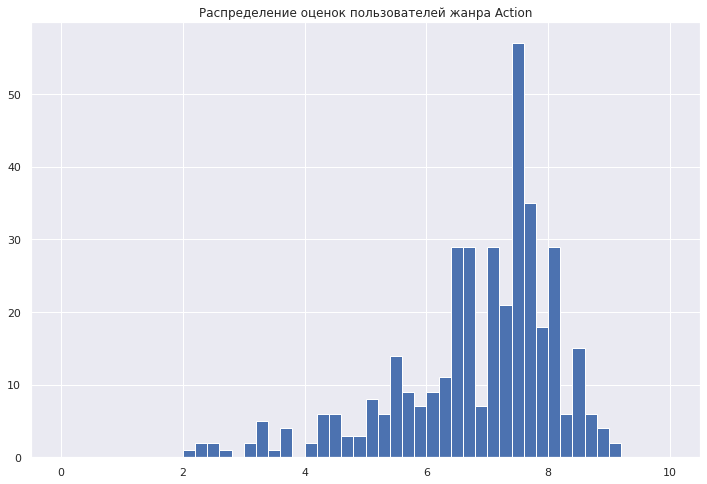

In [177]:
info(
    action, 
    'Распределение оценок пользователей жанра Action'
)

In [178]:
sports.describe()

count    160.000000
mean       5.238125
std        1.783427
min        0.200000
25%        4.100000
50%        5.500000
75%        6.500000
max        8.800000
Name: user_score, dtype: float64

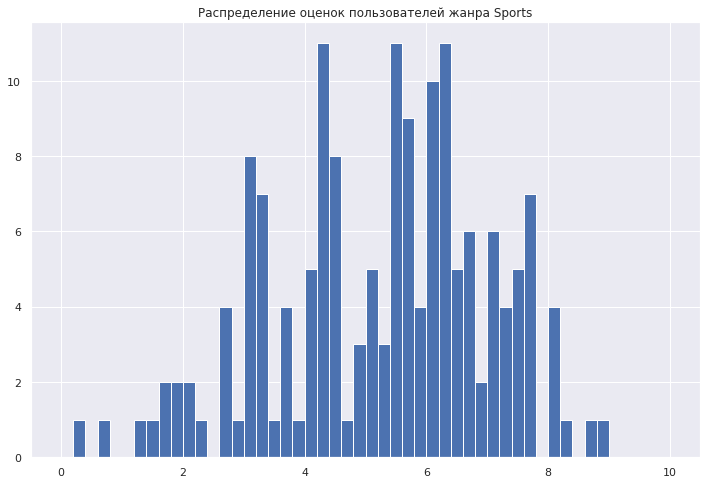

In [179]:
info(
    sports, 
    'Распределение оценок пользователей жанра Sports'
)

Исходя из полученных данных значения кажутся довольно похожими, графики распределения близки.
Проверим данное предположение на примере гипотезы:

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются

У нас разные по размеру выборки (отзывов на жанры Action в 1.6 раза больше, чем пользователей на жанры Sports). Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется метод st.ttest_ind, так же мы будем использовать параметр equal_var=True.

Если p-value будет меньше выбранного уровня значимости 0.05, то нулевую гипотезу о равенстве средних отвергнем. В противном случае делаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [180]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.4460039700704315e-20
Отвергаем нулевую гипотезу


Гипотеза не подтвердилась. Различие в пользовательских оценках жанров Action и Sports значительно.

# 6. Общий вывод

Целью данного анализа было на основании данных о продажах компьютерных игр выявить ряд закономерностей, которые определяют успешность игр.
В результате проведения анализа можем подвести следующие итоги:

1. Самыми потенциально прибыльными платформами с длинным жизненным циклом и высокими продажами являются платформы PS3/PS4, XOne, WiiU. (Самыми продаваемыми платформами признаны PS4 и XOne с рекордными продажами в 2018 году).
2. Спрос на компьютерные игры выше в Северной Америке, затем в Европе, ниже - в Японии и других странах.
3. Если опираться на регионы, то в Америке более популярны платформы разработчика Microsoft - на 2016 год это XOne, в Европе - PS4, в Японии - 3DS.
4. Из жанров рекомендуем присмотреться к Action, Shooters и Sports, для Японии более актуален Role-Playing.
5. Оценки пользователей на прибыль, как ни странно, не влияют.
6. Небольшое влияние на продажи оказывают оценки критиков, можно присмотреться к данному показателю при разработке рекламной кампании.
7. Во всех регионах, кроме Японии, самыми продаваемыми являются игры с рейтингом М категории 17+. В Японии наиболее актуален рейтинг Т - для подростков.

По итогам проверки гипотез можно сказать следующее:

1. Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - гипотеза не подтвердилась, средние пользовательские оценки Xbox One и PC различны.
2. Гипотеза 2: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные - гипотеза подтвердилась, различие в пользовательских оценках жанров Action и Sports не значительно.

Рекомендации для рекламного отдела:

1. Для проведения рекламной кампании первоначально необходимо определиться с аудиторией:
- в случае, если целевой аудиторией магазина являются Северная Америка и Европа, то упор необходимо делать на платформы PS4, XOne, на жанры Action, Shooter, Sports, на игры для взрослой аудитории 17+. 
- в случае, если целевой аудиторией выбраны пользователи Японии, то упор необходимо делать на платформы 3DS, PS4, на жанры Role-Playing и Action, на игры для подростковой аудитории 13+.

2. На отзывы пользователей и критиков внимание обращать не стоит, т.к. они на продажи не влияют.
3. Рекомендовано выбирать аудиторию Северной Америки и Европы, т.к. она составляет почти 80% рынка.

